In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Replace 'path/to/your/file.txt' with the actual path to your file in Google Drive
img_1 = '/content/drive/My Drive/Colab Notebooks/Computer_Vision/OpenCV/screenshot_2.png'
img_2 = '/content/drive/My Drive/Colab Notebooks/Computer_Vision/OpenCV/screenshot_3.png'
img_3 = '/content/drive/My Drive/Colab Notebooks/Computer_Vision/OpenCV/screenshot_4.png'

Mounted at /content/drive


In [96]:
# Library instalation (OpenCV)
!pip install opencv-python-headless matplotlib

import cv2
import matplotlib.pyplot as plt
import numpy as np

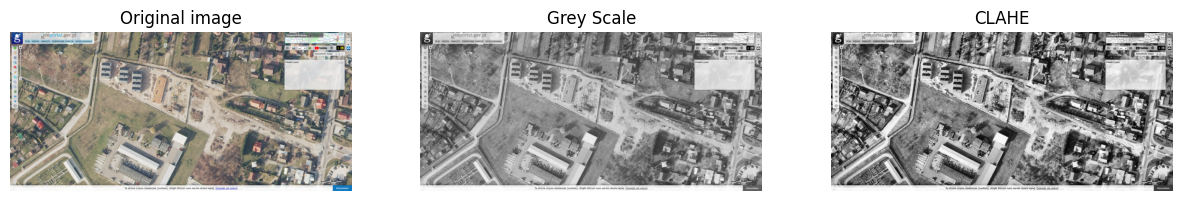

In [97]:
image = cv2.imread(img_1)

# Load Checking
if image is None:
    raise FileNotFoundError(f"File can't be loaded: {img_1}")

# Converstion to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Conversion to grey scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(gray)

# Show Plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_rgb)
axs[0].set_title("Original image")
axs[0].axis("off")

axs[1].imshow(gray, cmap='gray')
axs[1].set_title("Grey Scale")
axs[1].axis("off")

axs[2].imshow(gray_clahe, cmap='gray')
axs[2].set_title("CLAHE")
axs[2].axis("off")

plt.show()

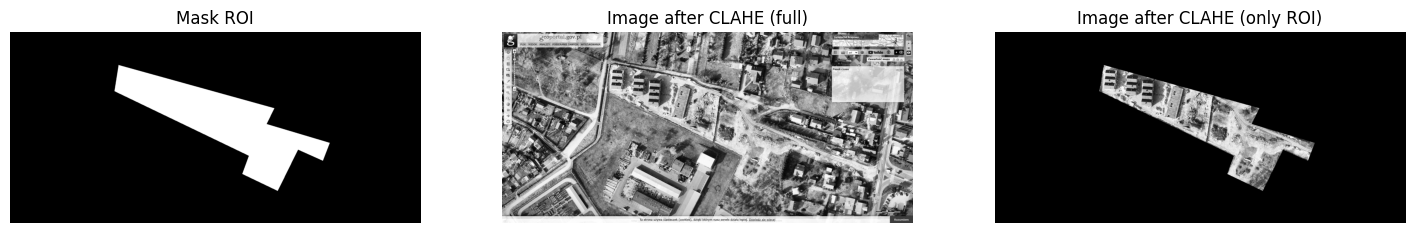

In [98]:
# Points list polygon ROI
roi_points = np.array([
    [506,154],
    [1234,356],
    [1198,430],
    [1493,518],
    [1461,601],
    [1345,549],
    [1250,742],
    [1085,663],
    [1116,578],
    [488,276],
    [507,156]
], dtype=np.int32)

# Creating empty mask
mask = np.zeros_like(gray_clahe, dtype=np.uint8)

# Fill mask inside
cv2.fillPoly(mask, [roi_points], 255)

# Put mask on Image after CLAHE
gray_clahe_roi = cv2.bitwise_and(gray_clahe, mask)

# Visulalization ROI
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(mask, cmap='gray')
axs[0].set_title("Mask ROI")
axs[0].axis("off")

axs[1].imshow(gray_clahe, cmap='gray')
axs[1].set_title("Image after CLAHE (full)")
axs[1].axis("off")

axs[2].imshow(gray_clahe_roi, cmap='gray')
axs[2].set_title("Image after CLAHE (only ROI)")
axs[2].axis("off")

plt.show()


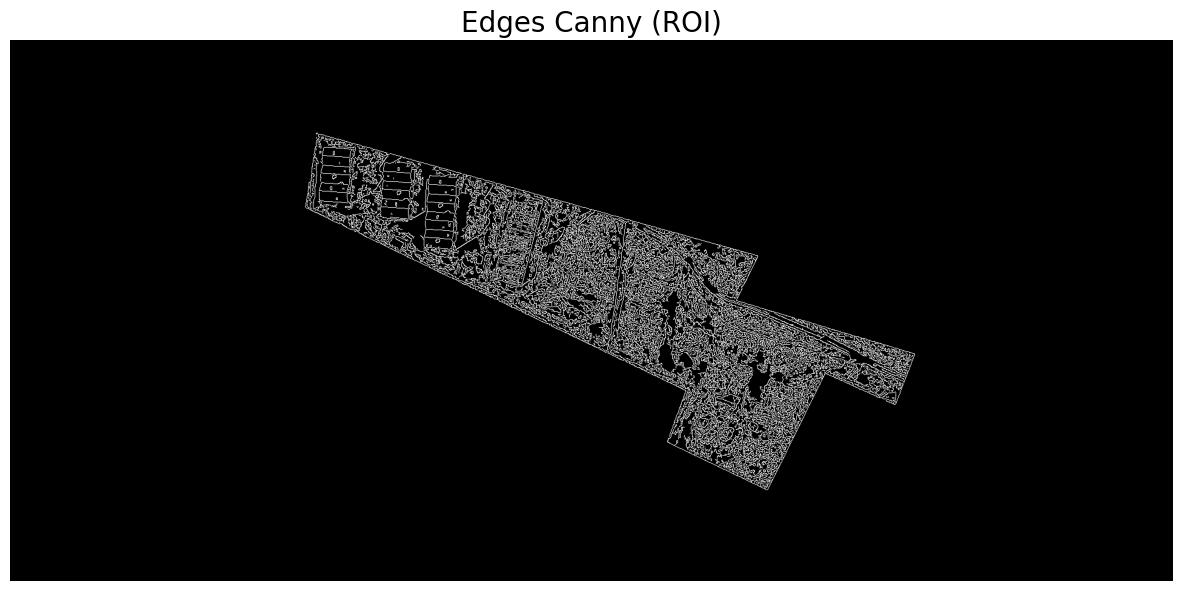

In [100]:
# Detection edges Canny on Image limited mask ROI
edges_roi = cv2.Canny(
    gray_clahe_roi,
    threshold1=25,  # lower threshold
    threshold2=140, # upper threshold
    apertureSize=3
)

# Single plot
plt.figure(figsize=(15, 15))
plt.imshow(edges_roi, cmap='gray')
plt.title("Edges Canny (ROI)", fontsize=20)
plt.axis("off")
plt.show()


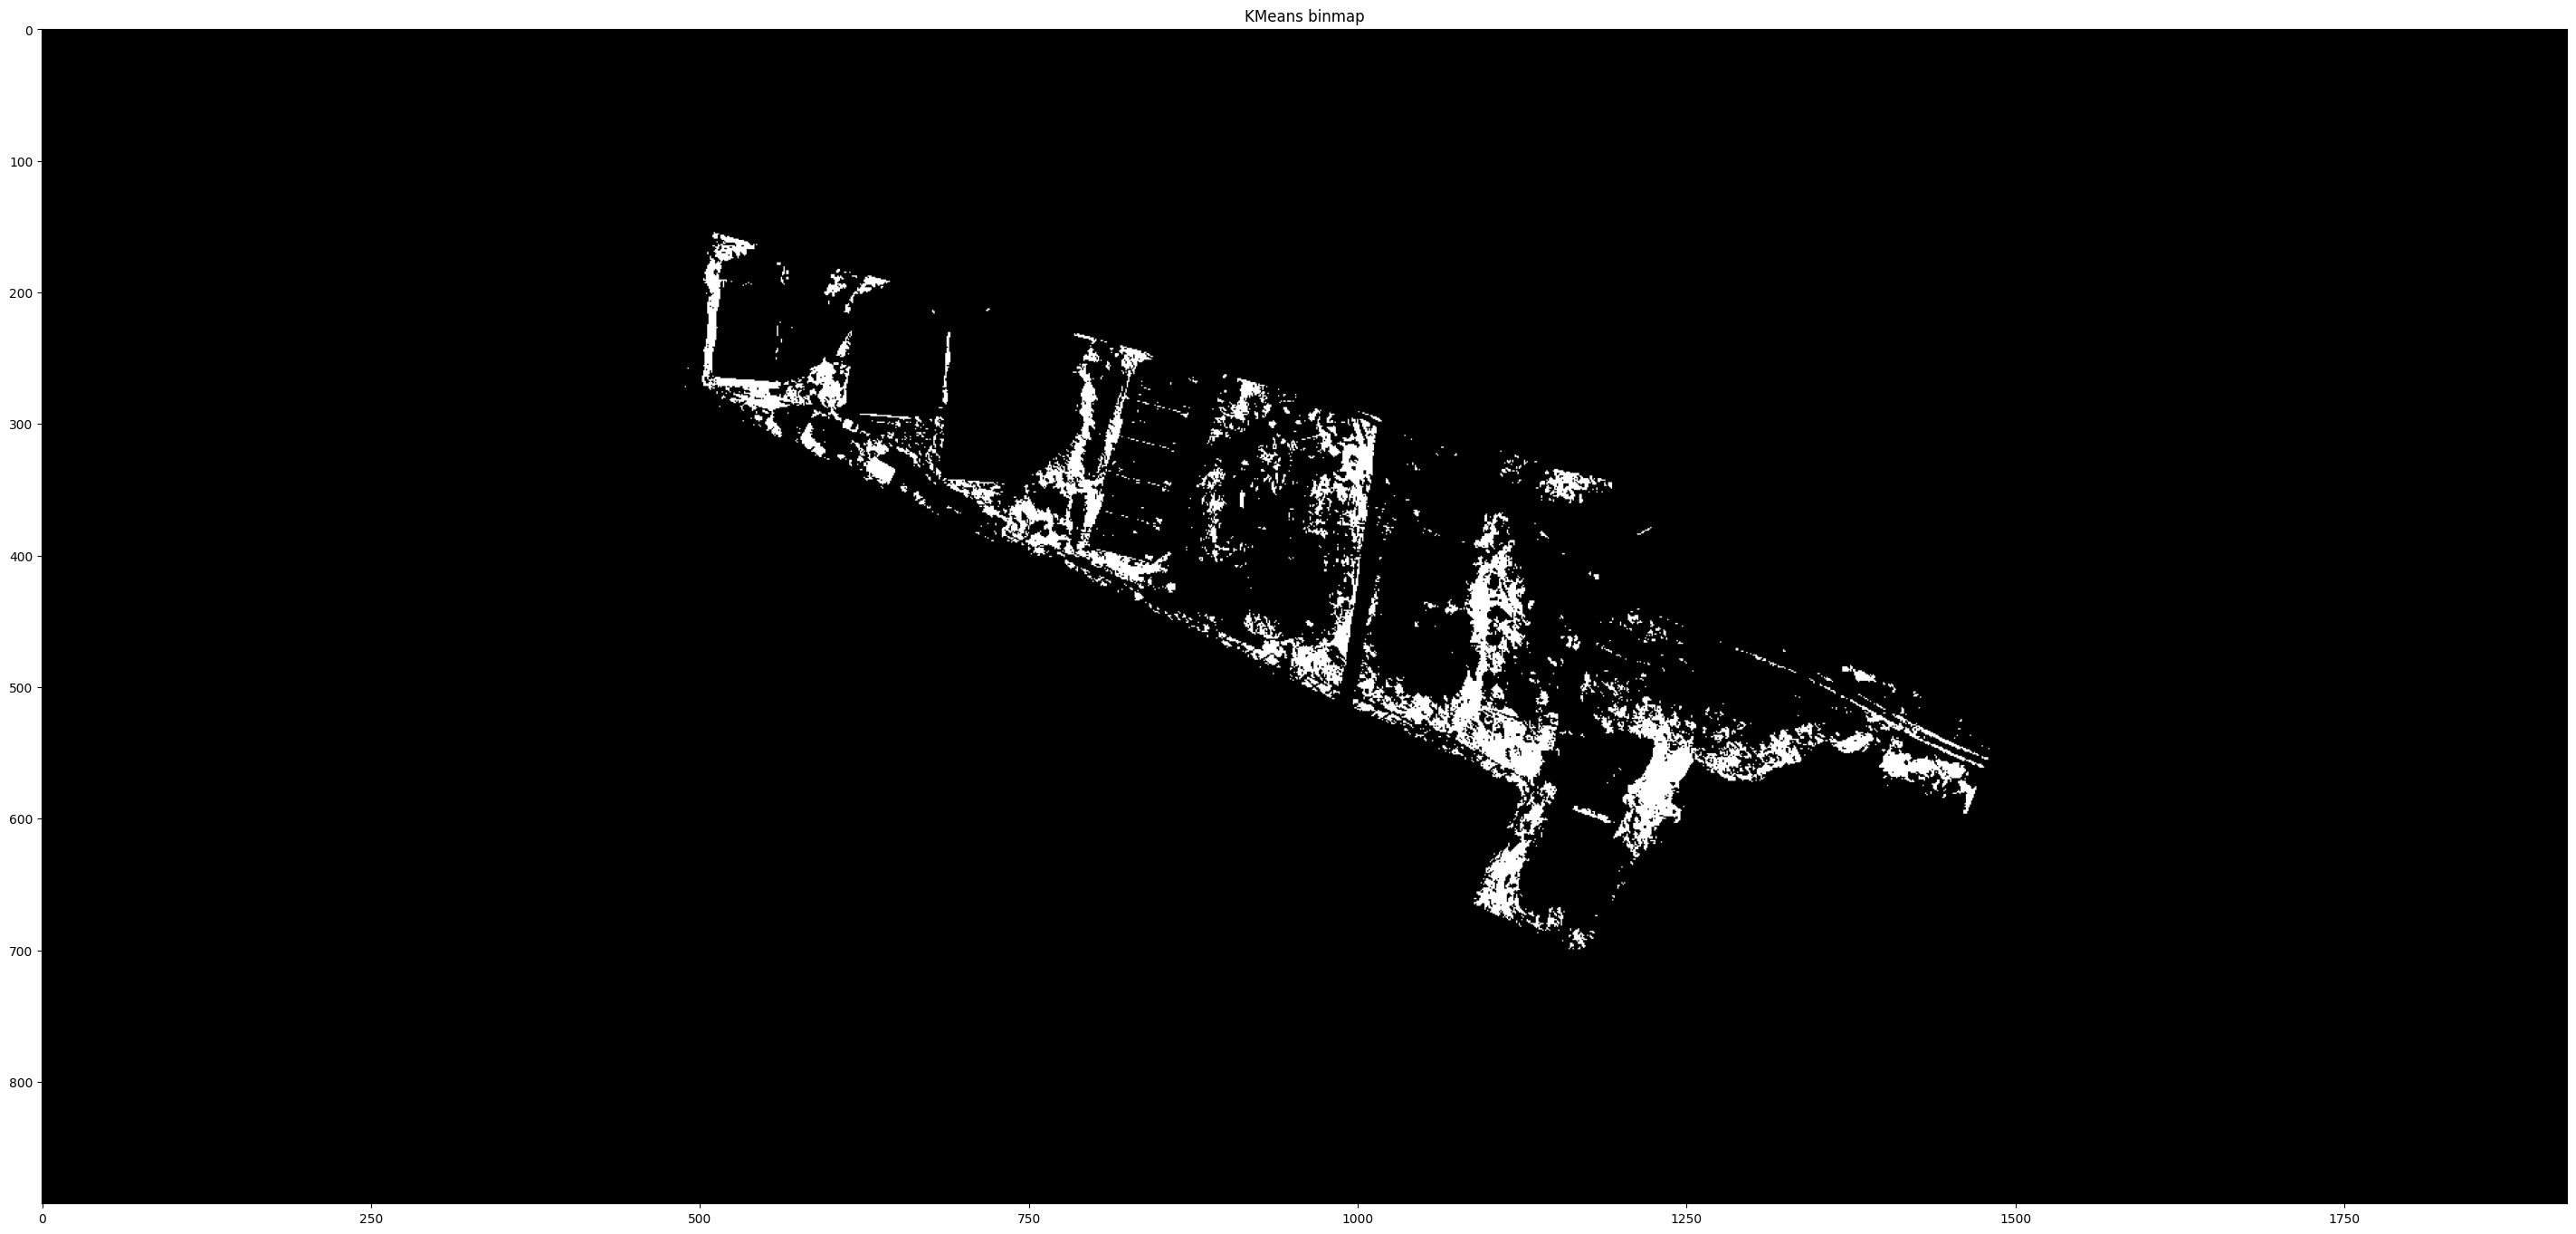

In [101]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- parameters ---
K_INIT = 8
N_INIT = 10
MAX_ITER = 100
FG_BY_BRIGHTNESS = 1   # 1 → brightest, 0 → darknest

def segment_with_kmeans(roi_clahe_map):
    """
    roi_clahe_map : 2D numpy array (np.uint8)
                    -> image after CLAHE with putted ROI
                       (poza ROI np. wartości 0)
    """
    bin_map = np.zeros_like(roi_clahe_map, dtype=np.uint8)
    roi_y, roi_x = np.where(roi_clahe_map > 0)

    if roi_y.size >= 10:
        values = roi_clahe_map[roi_y, roi_x].astype(np.float32).reshape(-1, 1)
        km = KMeans(
            n_clusters=max(2, K_INIT),
            n_init=max(1, N_INIT),
            max_iter=max(10, MAX_ITER),
            random_state=42
        )
        labels = km.fit_predict(values)
        centers = km.cluster_centers_.flatten()

        # choice cluster foreground
        fg_label = int(np.argmax(centers)) if FG_BY_BRIGHTNESS == 1 else int(np.argmin(centers))
        bin_vals = (labels == fg_label).astype(np.uint8) * 255
        bin_map[roi_y, roi_x] = bin_vals

    return bin_map

# --- demo ---
bin_map = segment_with_kmeans(gray_clahe_roi)

plt.figure(figsize=(36,36))
plt.imshow(bin_map, cmap="gray")
plt.title("KMeans binmap")
plt.show()


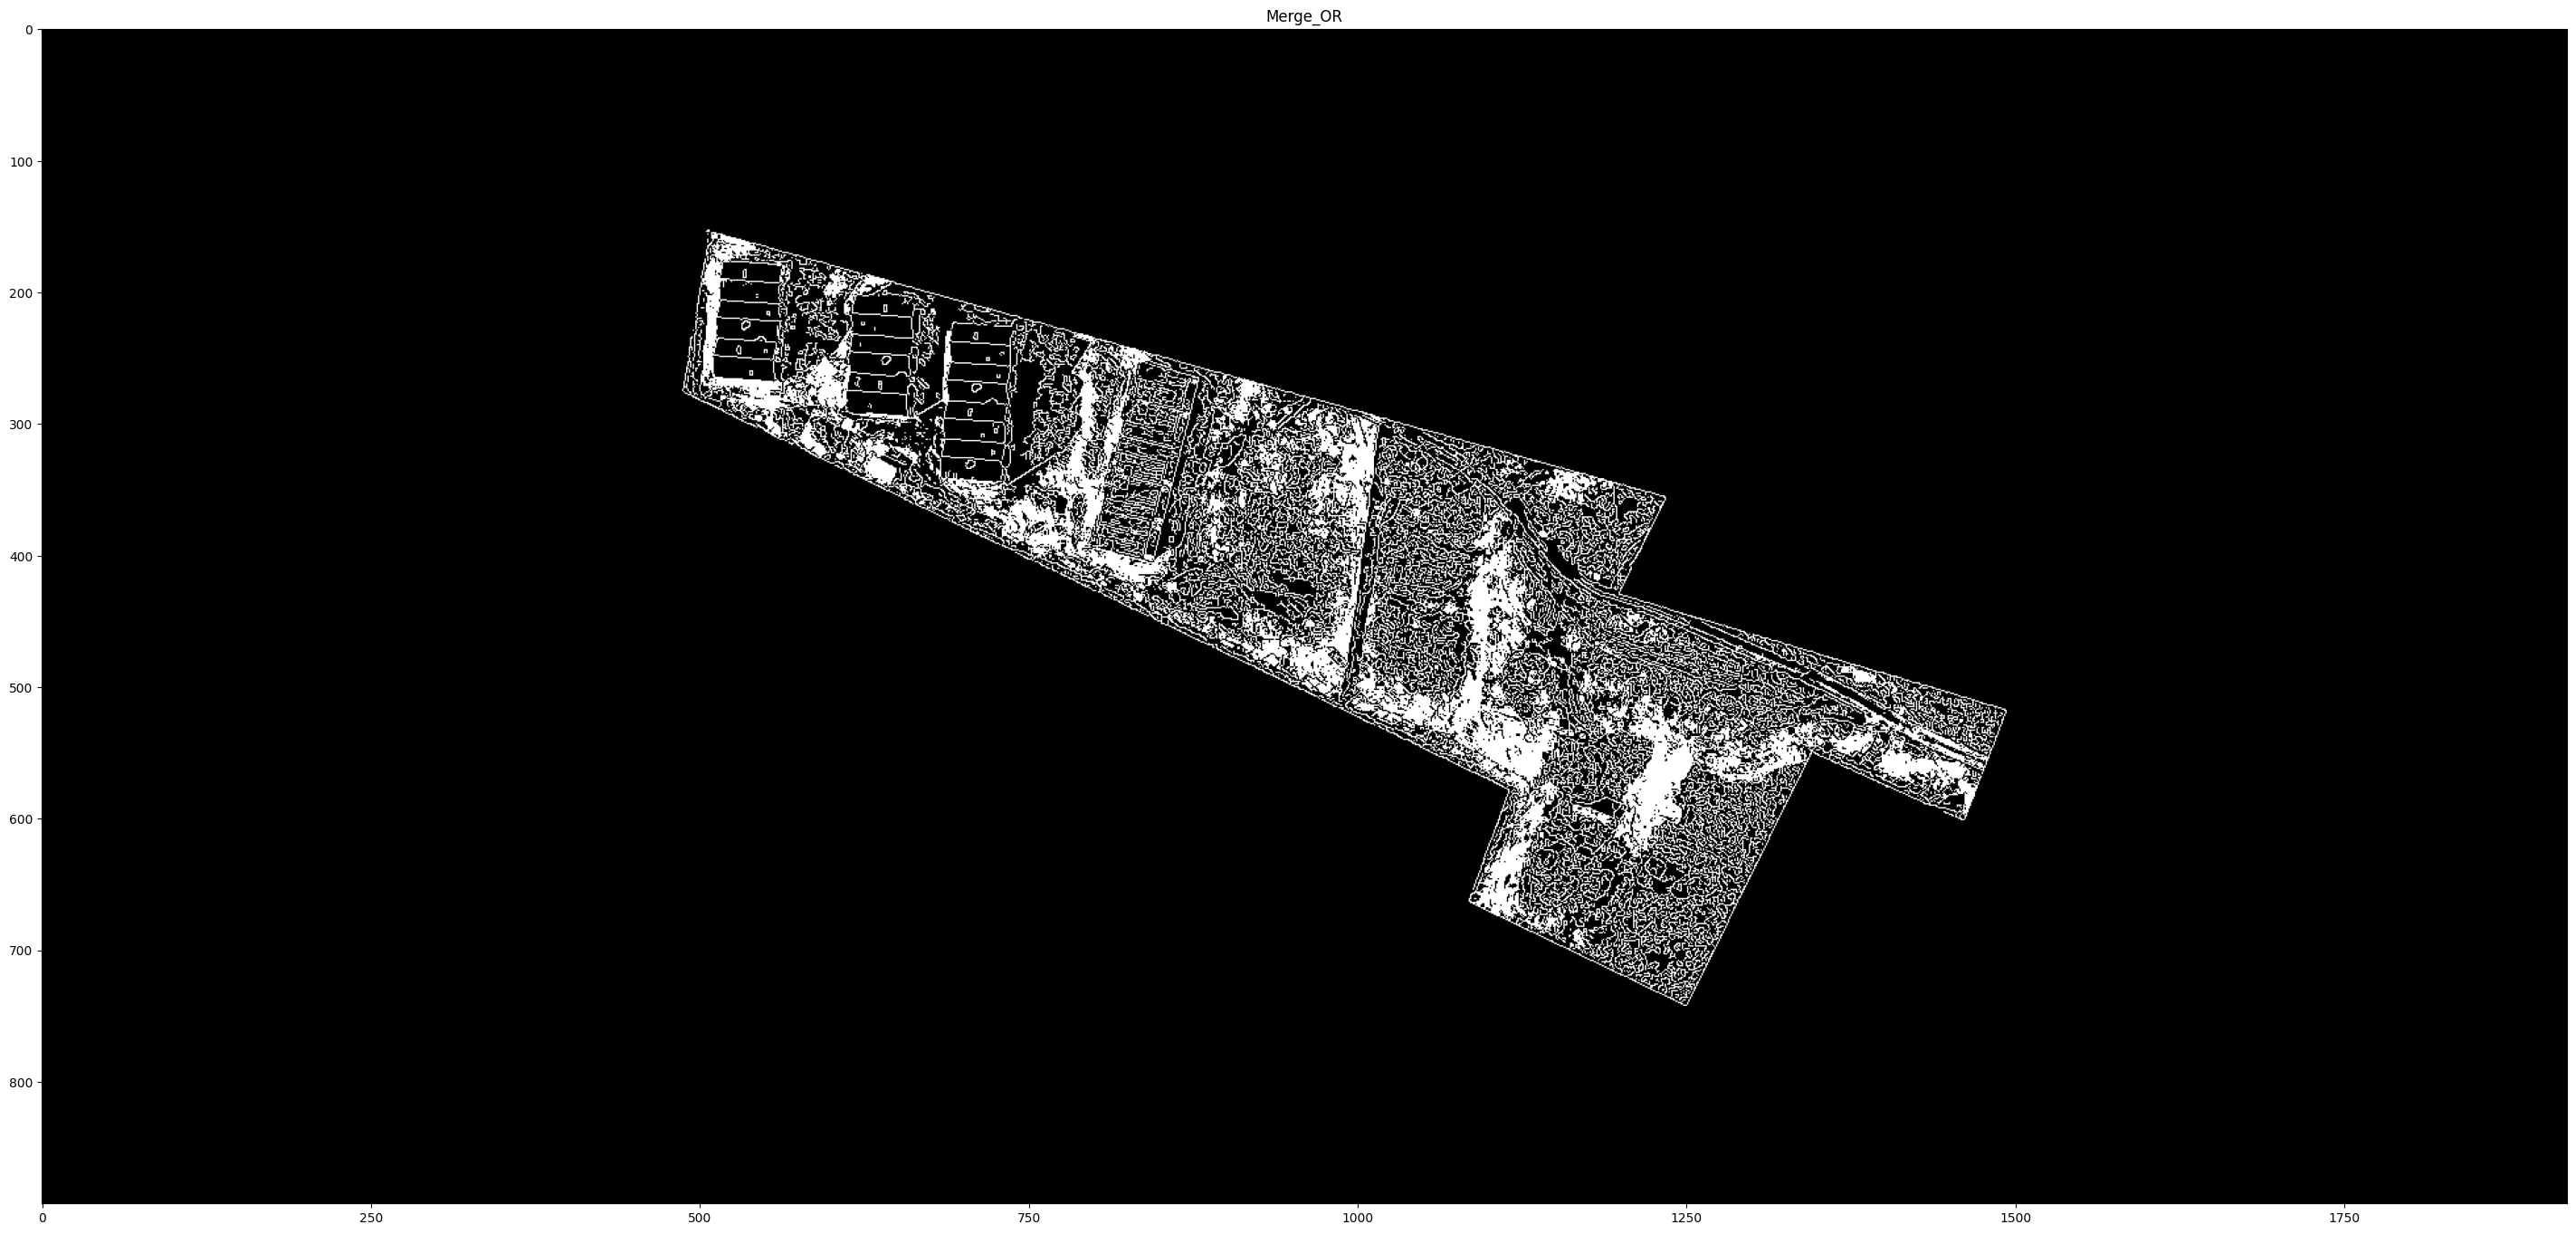

In [105]:
# Merge operation between Canny and Kmeans Cluster

merged_or = cv2.bitwise_or(bin_map, edges_roi)

plt.figure(figsize=(36,36))
plt.imshow(merged_or, cmap="gray")
plt.title("Merge_OR")
plt.show()

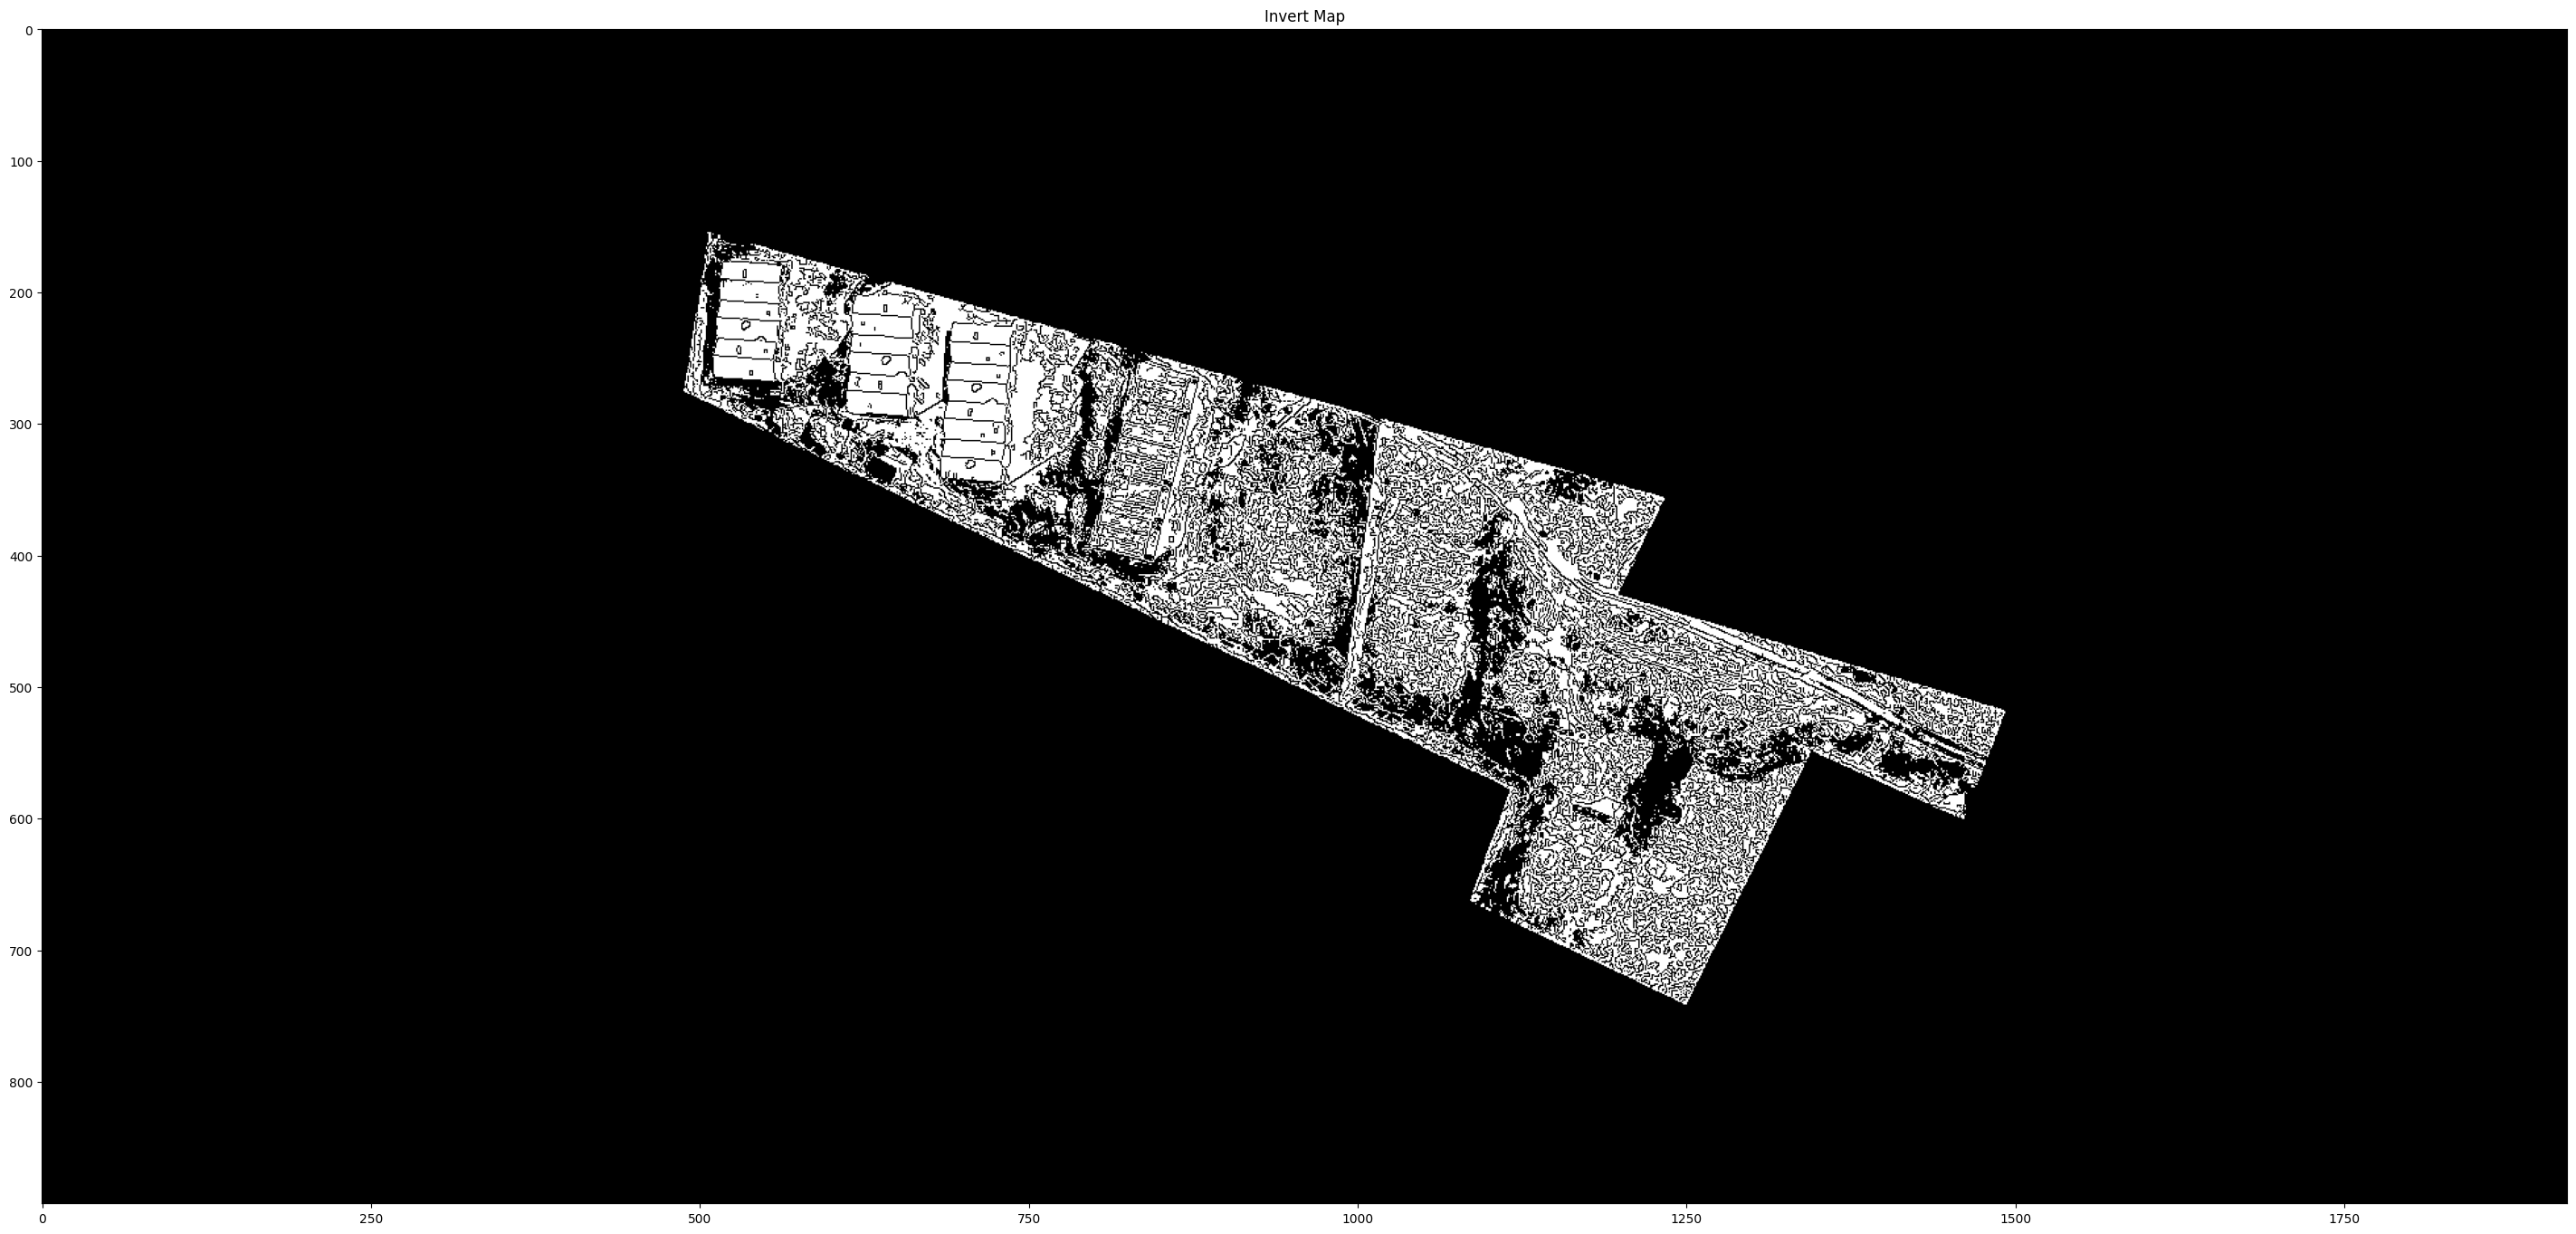

In [106]:
def invert_inside_roi(bin_map, roi_mask):
    """
    bin_map : 2D numpy array (uint8, 0/255) - binar map after KMeans
    roi_mask: 2D numpy array (uint8, 0/255) - mask ROI

    return : 2D numpy array (uint8, 0/255) - Inverted only in ROI
    """
    # classic inversion full maps
    inverted = cv2.bitwise_not(bin_map)

    # forcing black outside the ROI
    inverted_roi = cv2.bitwise_and(inverted, roi_mask)

    return inverted_roi

invert_map = invert_inside_roi(merged_or, mask)

plt.figure(figsize=(36,36))
plt.imshow(invert_map, cmap="gray")
plt.title("Invert Map")
plt.show()


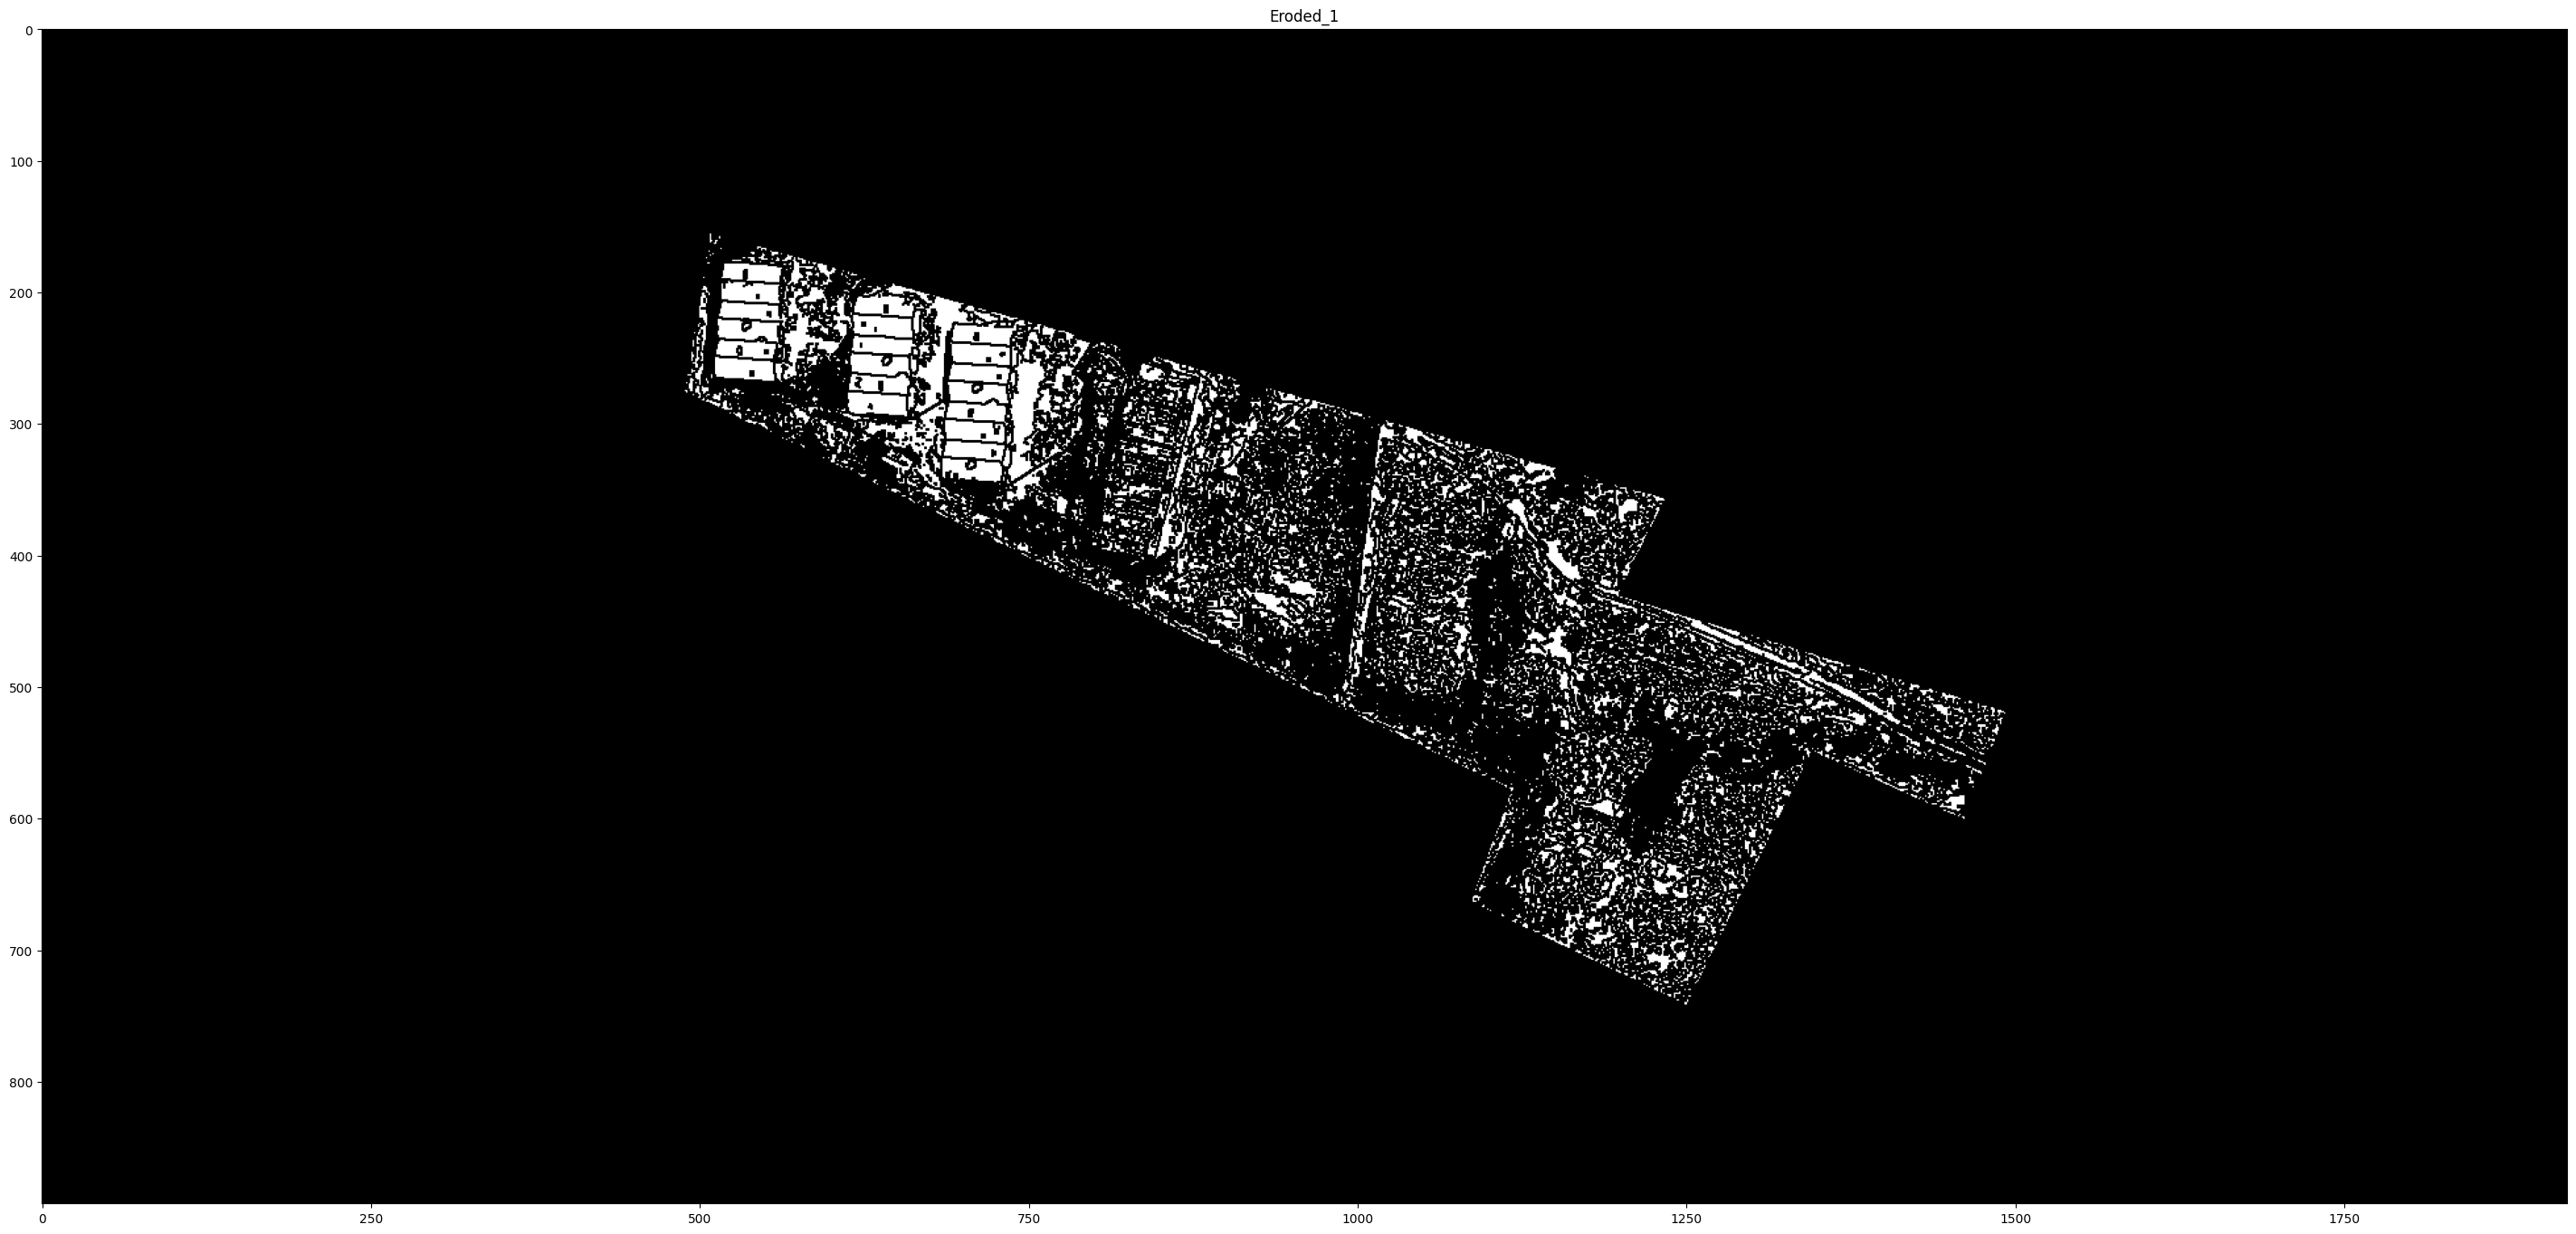

In [116]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# Erosion
eroded = cv2.erode(invert_map, kernel, iterations=1)

plt.figure(figsize=(36,36))
plt.imshow(eroded, cmap="gray")
plt.title("Eroded_1")
plt.show()



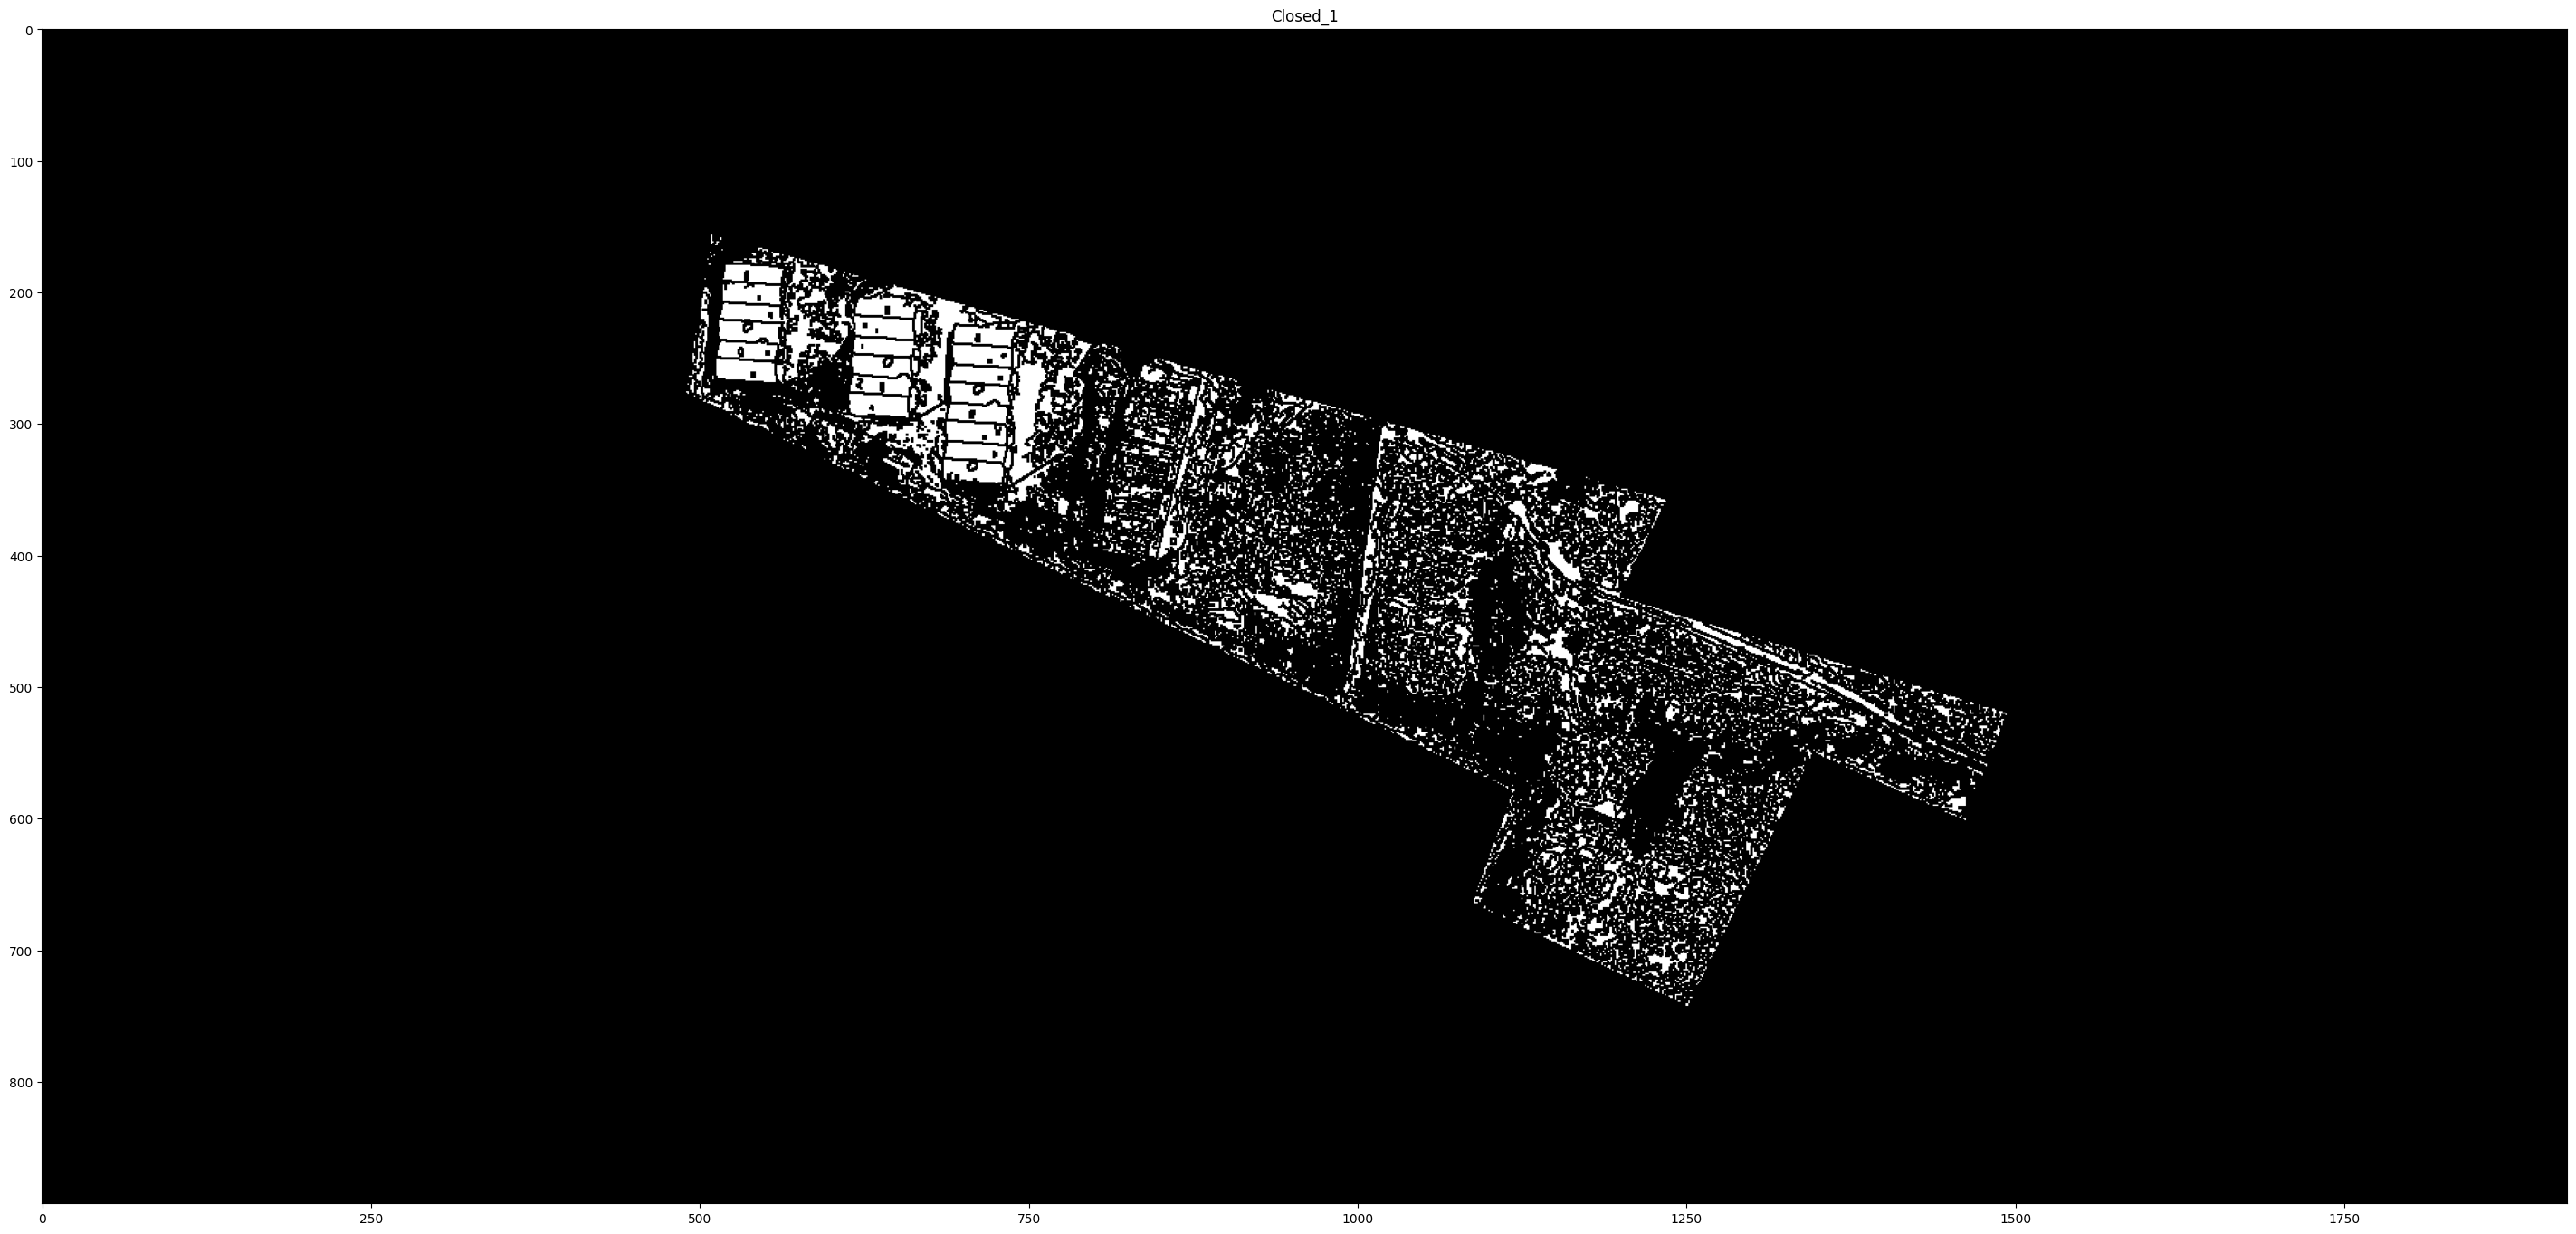

In [117]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# Closing
closed = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, kernel, iterations=1)

plt.figure(figsize=(36,36))
plt.imshow(closed, cmap="gray")
plt.title("Closed_1")
plt.show()

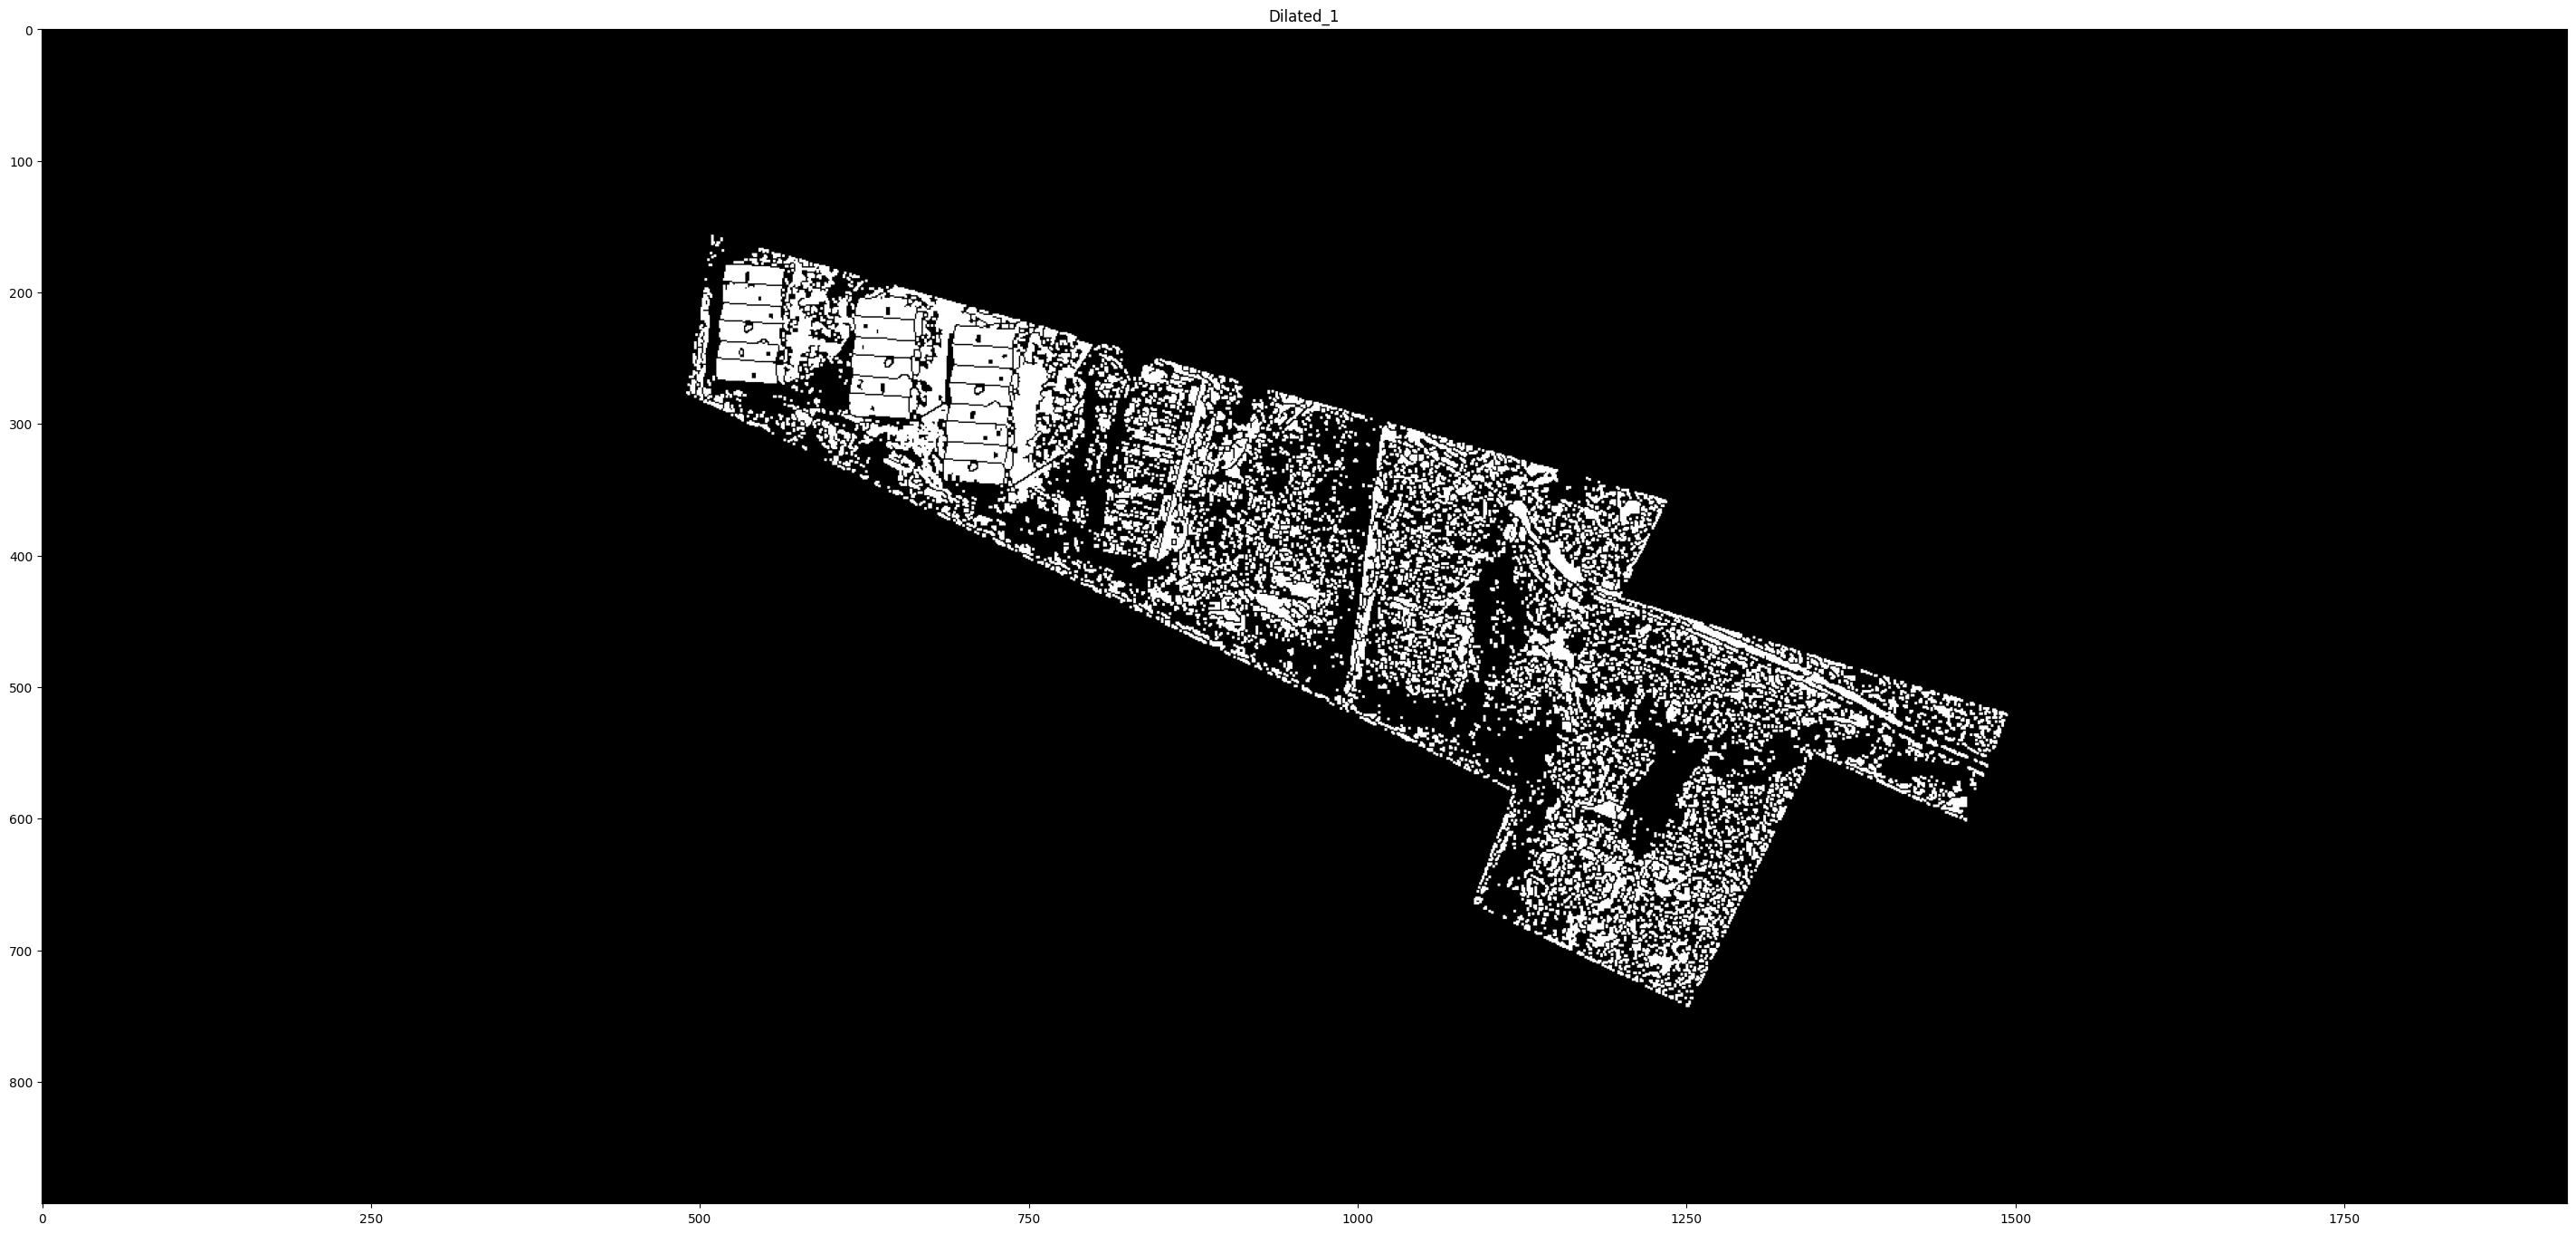

In [118]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# dilatation
dilated = cv2.dilate(closed, kernel, iterations=1)

plt.figure(figsize=(36,36))
plt.imshow(dilated, cmap="gray")
plt.title("Dilated_1")
plt.show()

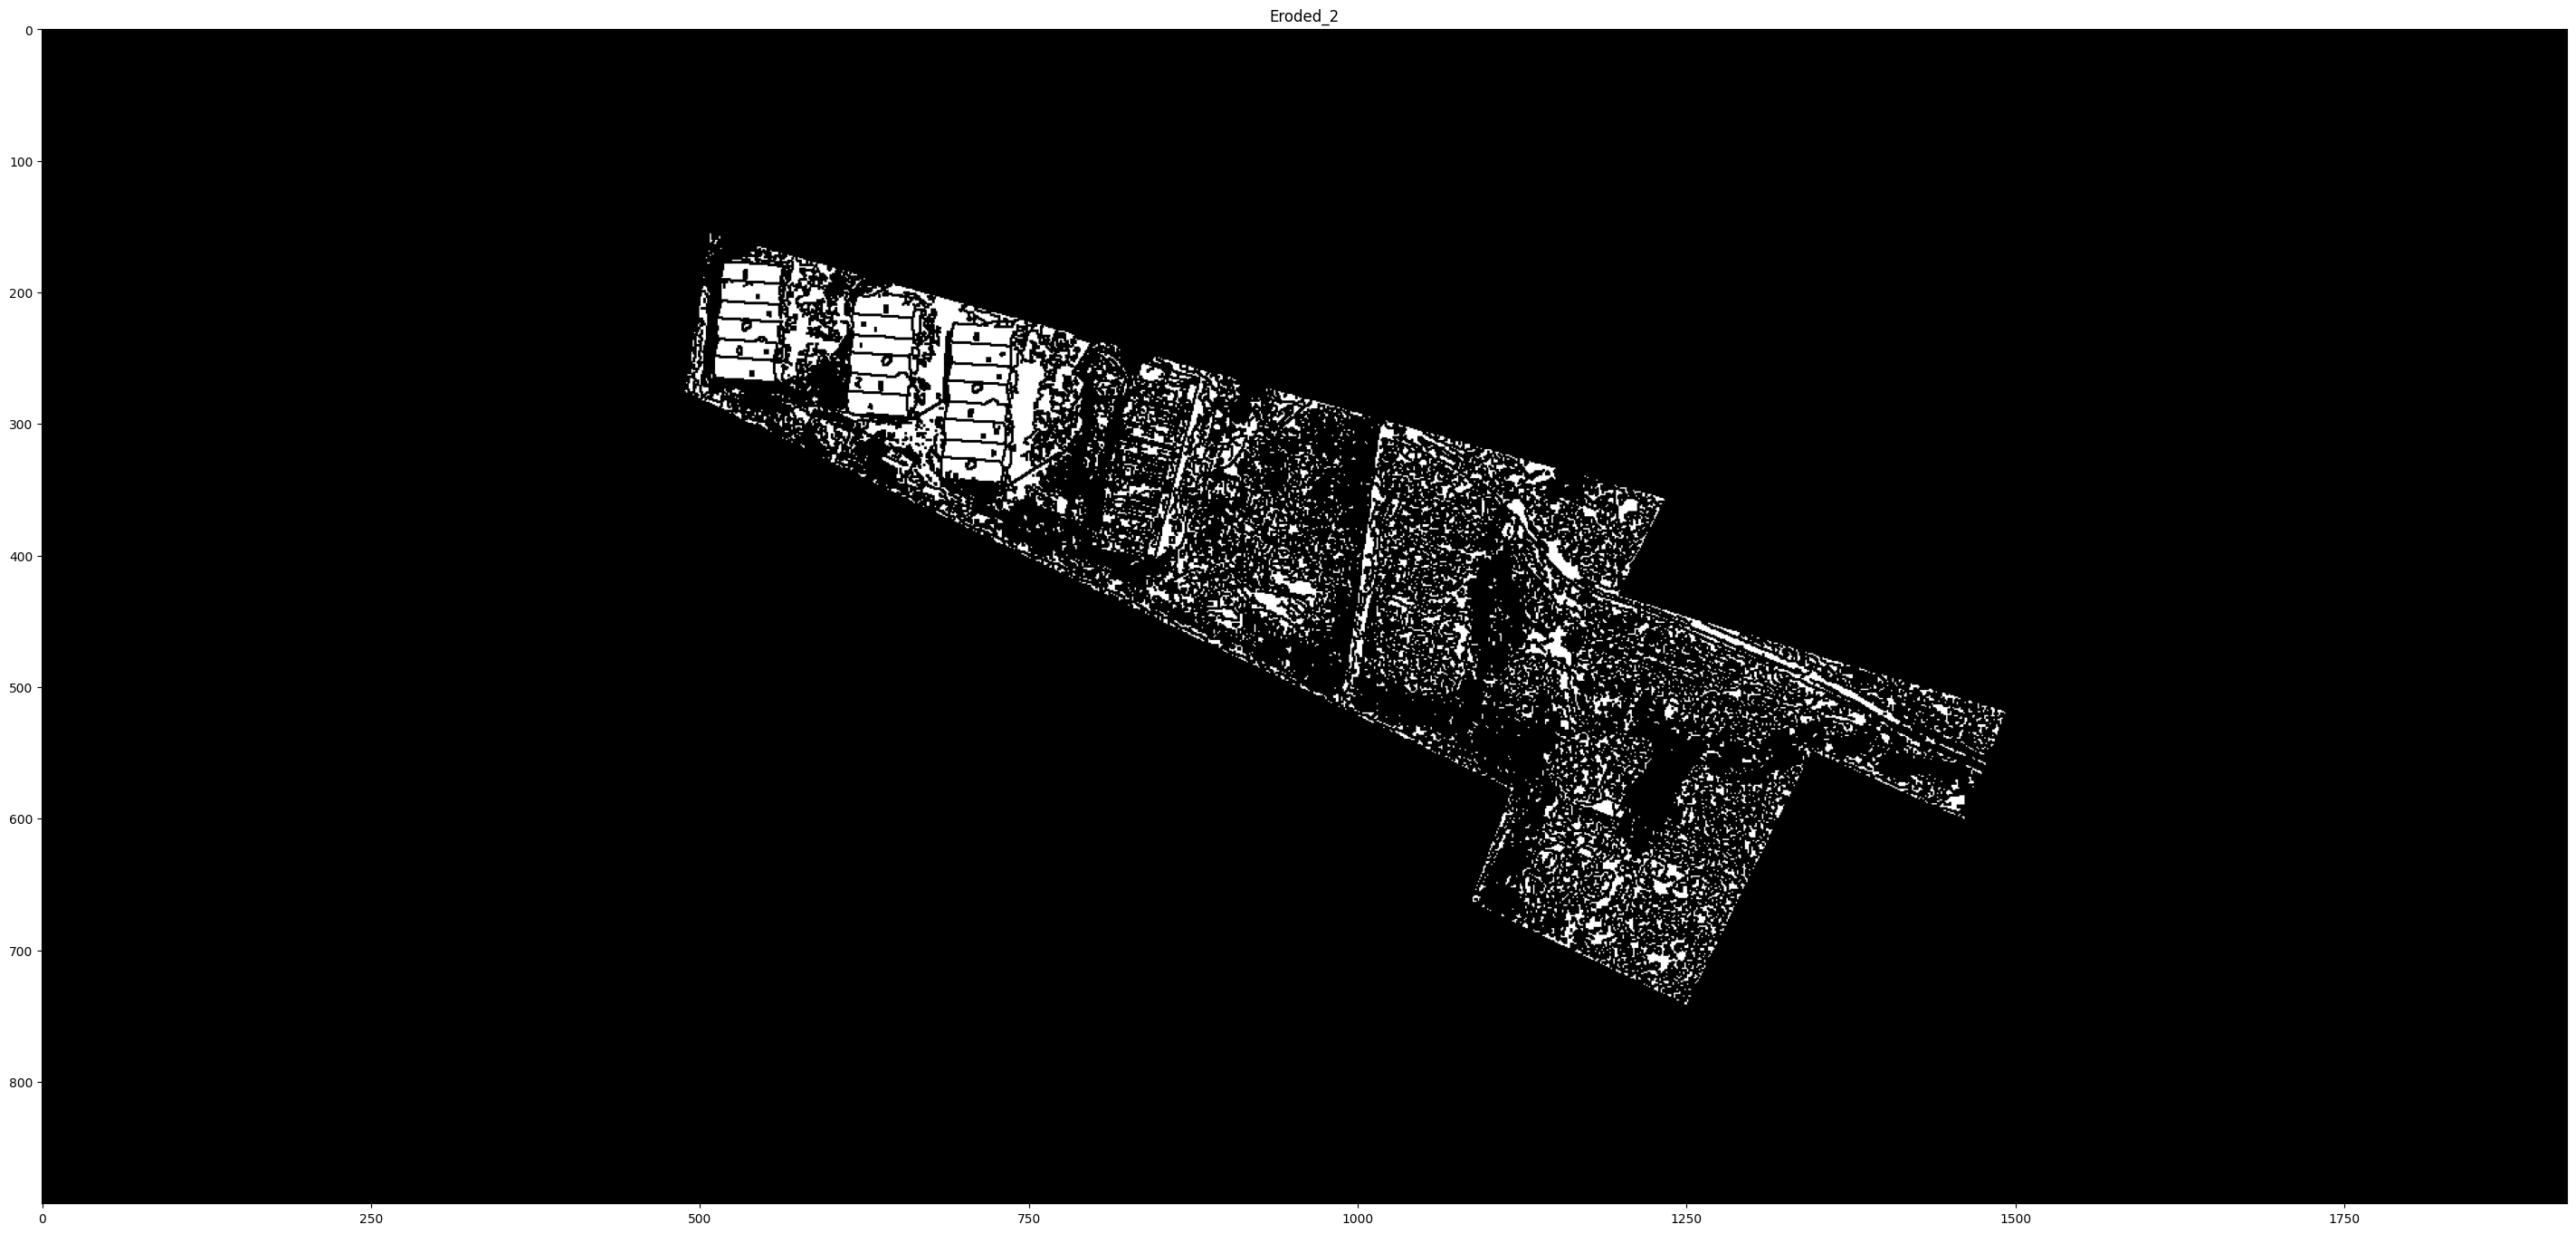

In [119]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# erosion
eroded_2 = cv2.erode(invert_map, kernel, iterations=1)

plt.figure(figsize=(36,36))
plt.imshow(eroded_2, cmap="gray")
plt.title("Eroded_2")
plt.show()


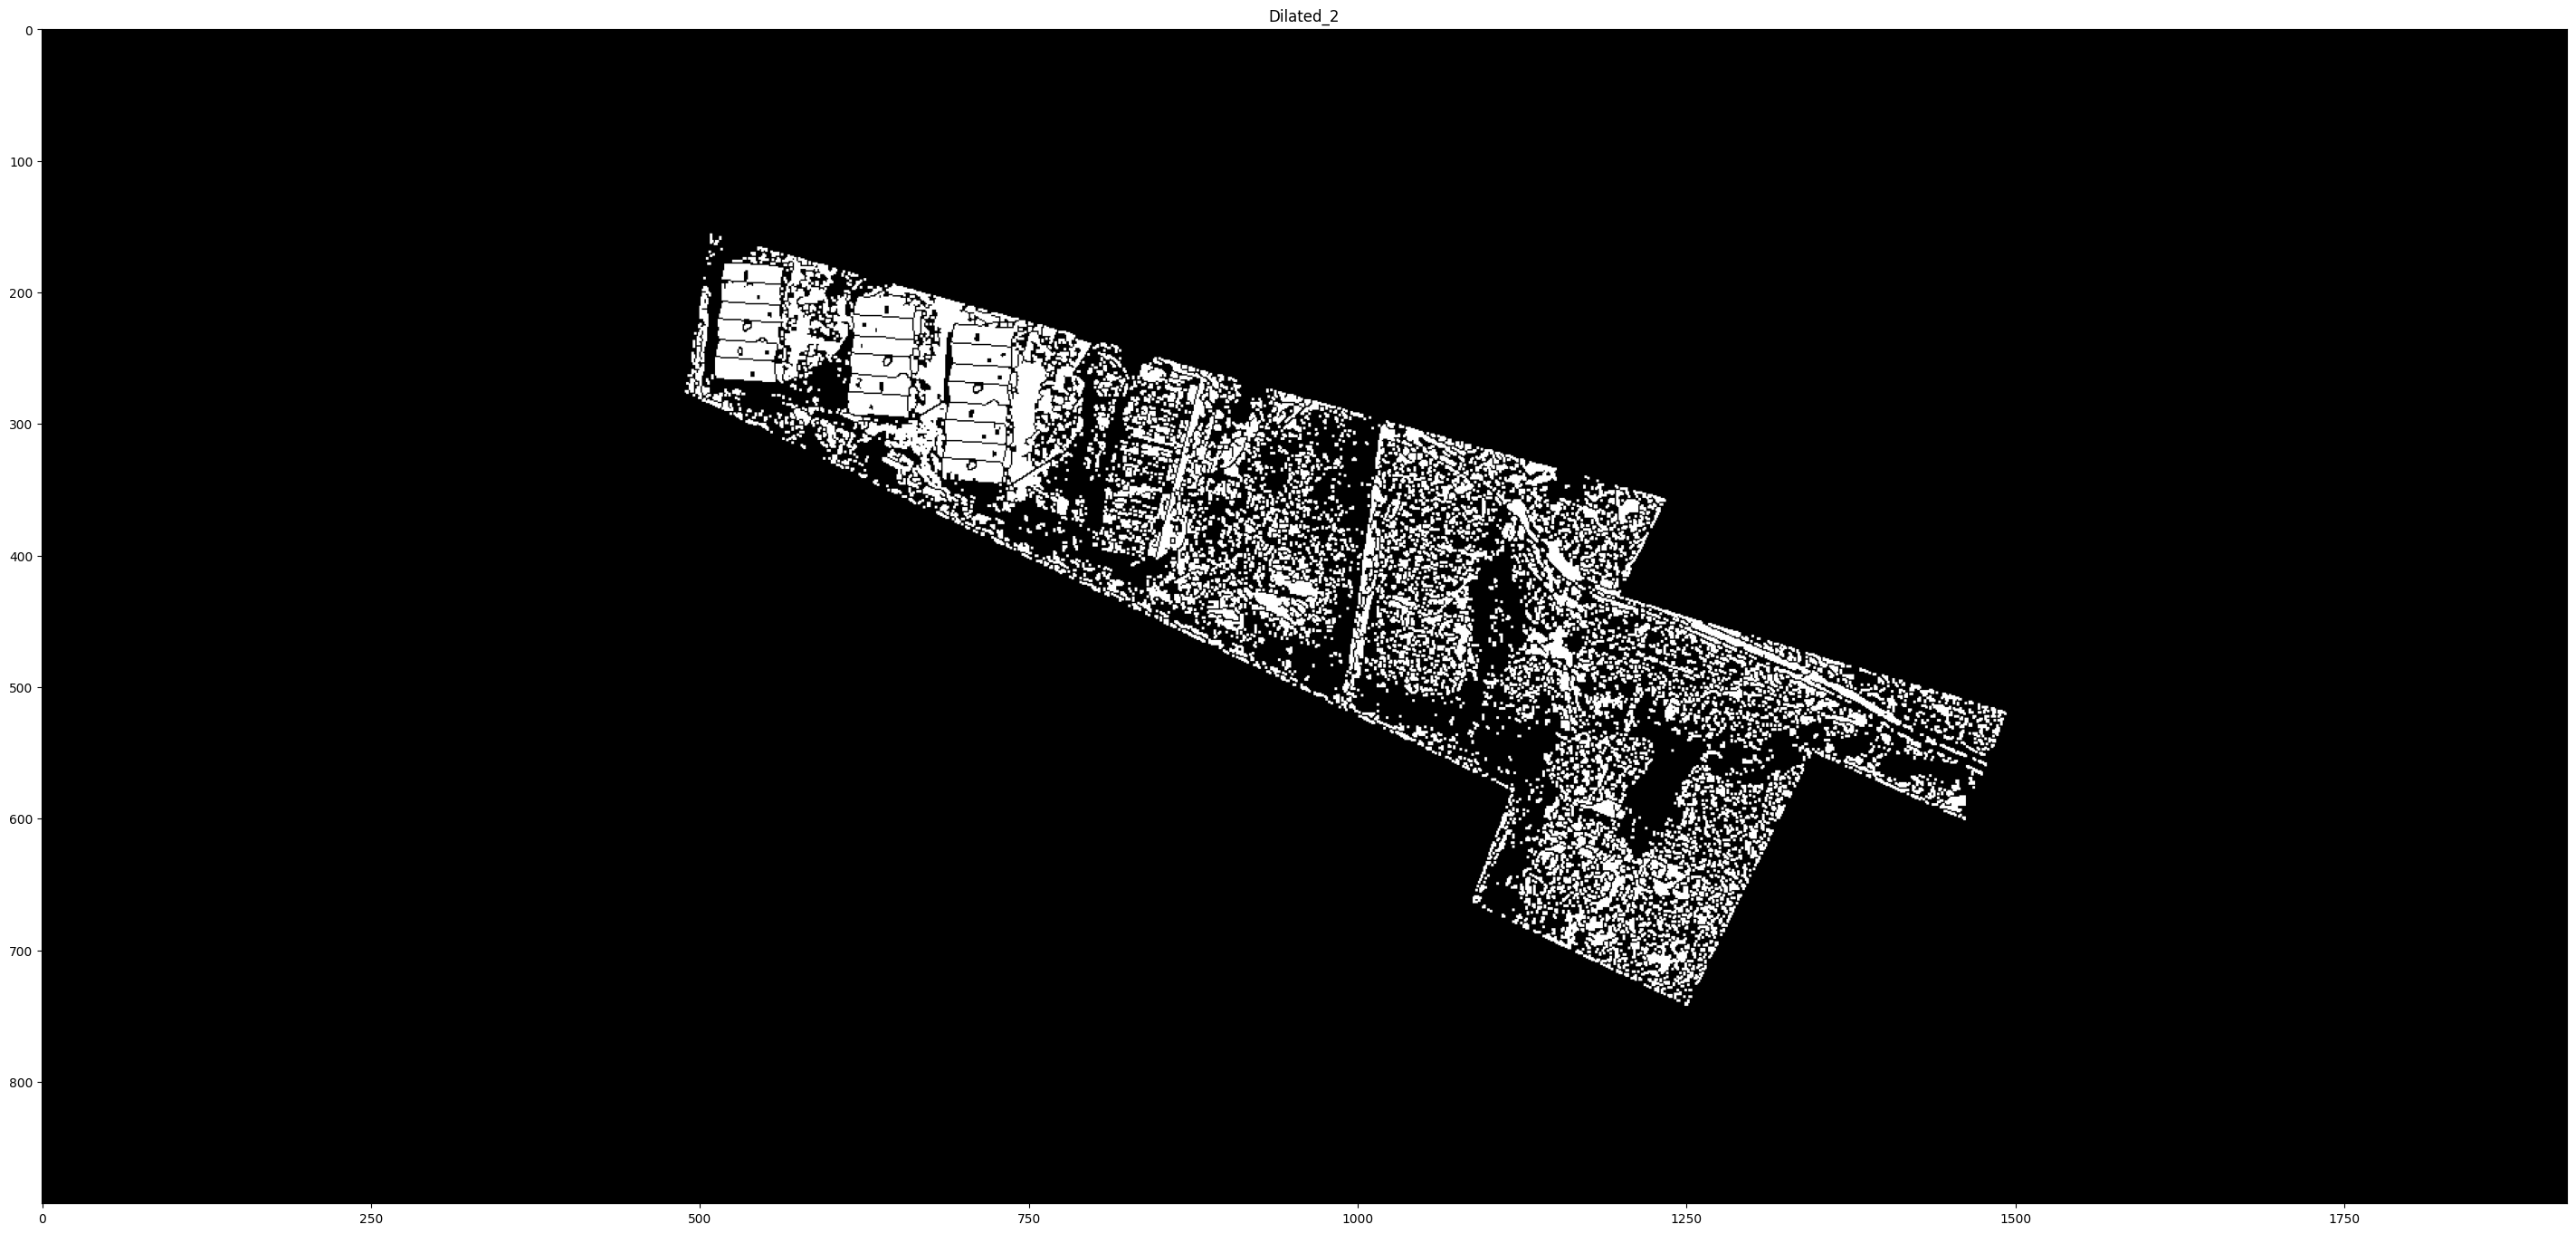

In [120]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# dilatation
dilated_2 = cv2.dilate(eroded_2, kernel, iterations=1)

plt.figure(figsize=(36,36))
plt.imshow(dilated_2, cmap="gray")
plt.title("Dilated_2")
plt.show()

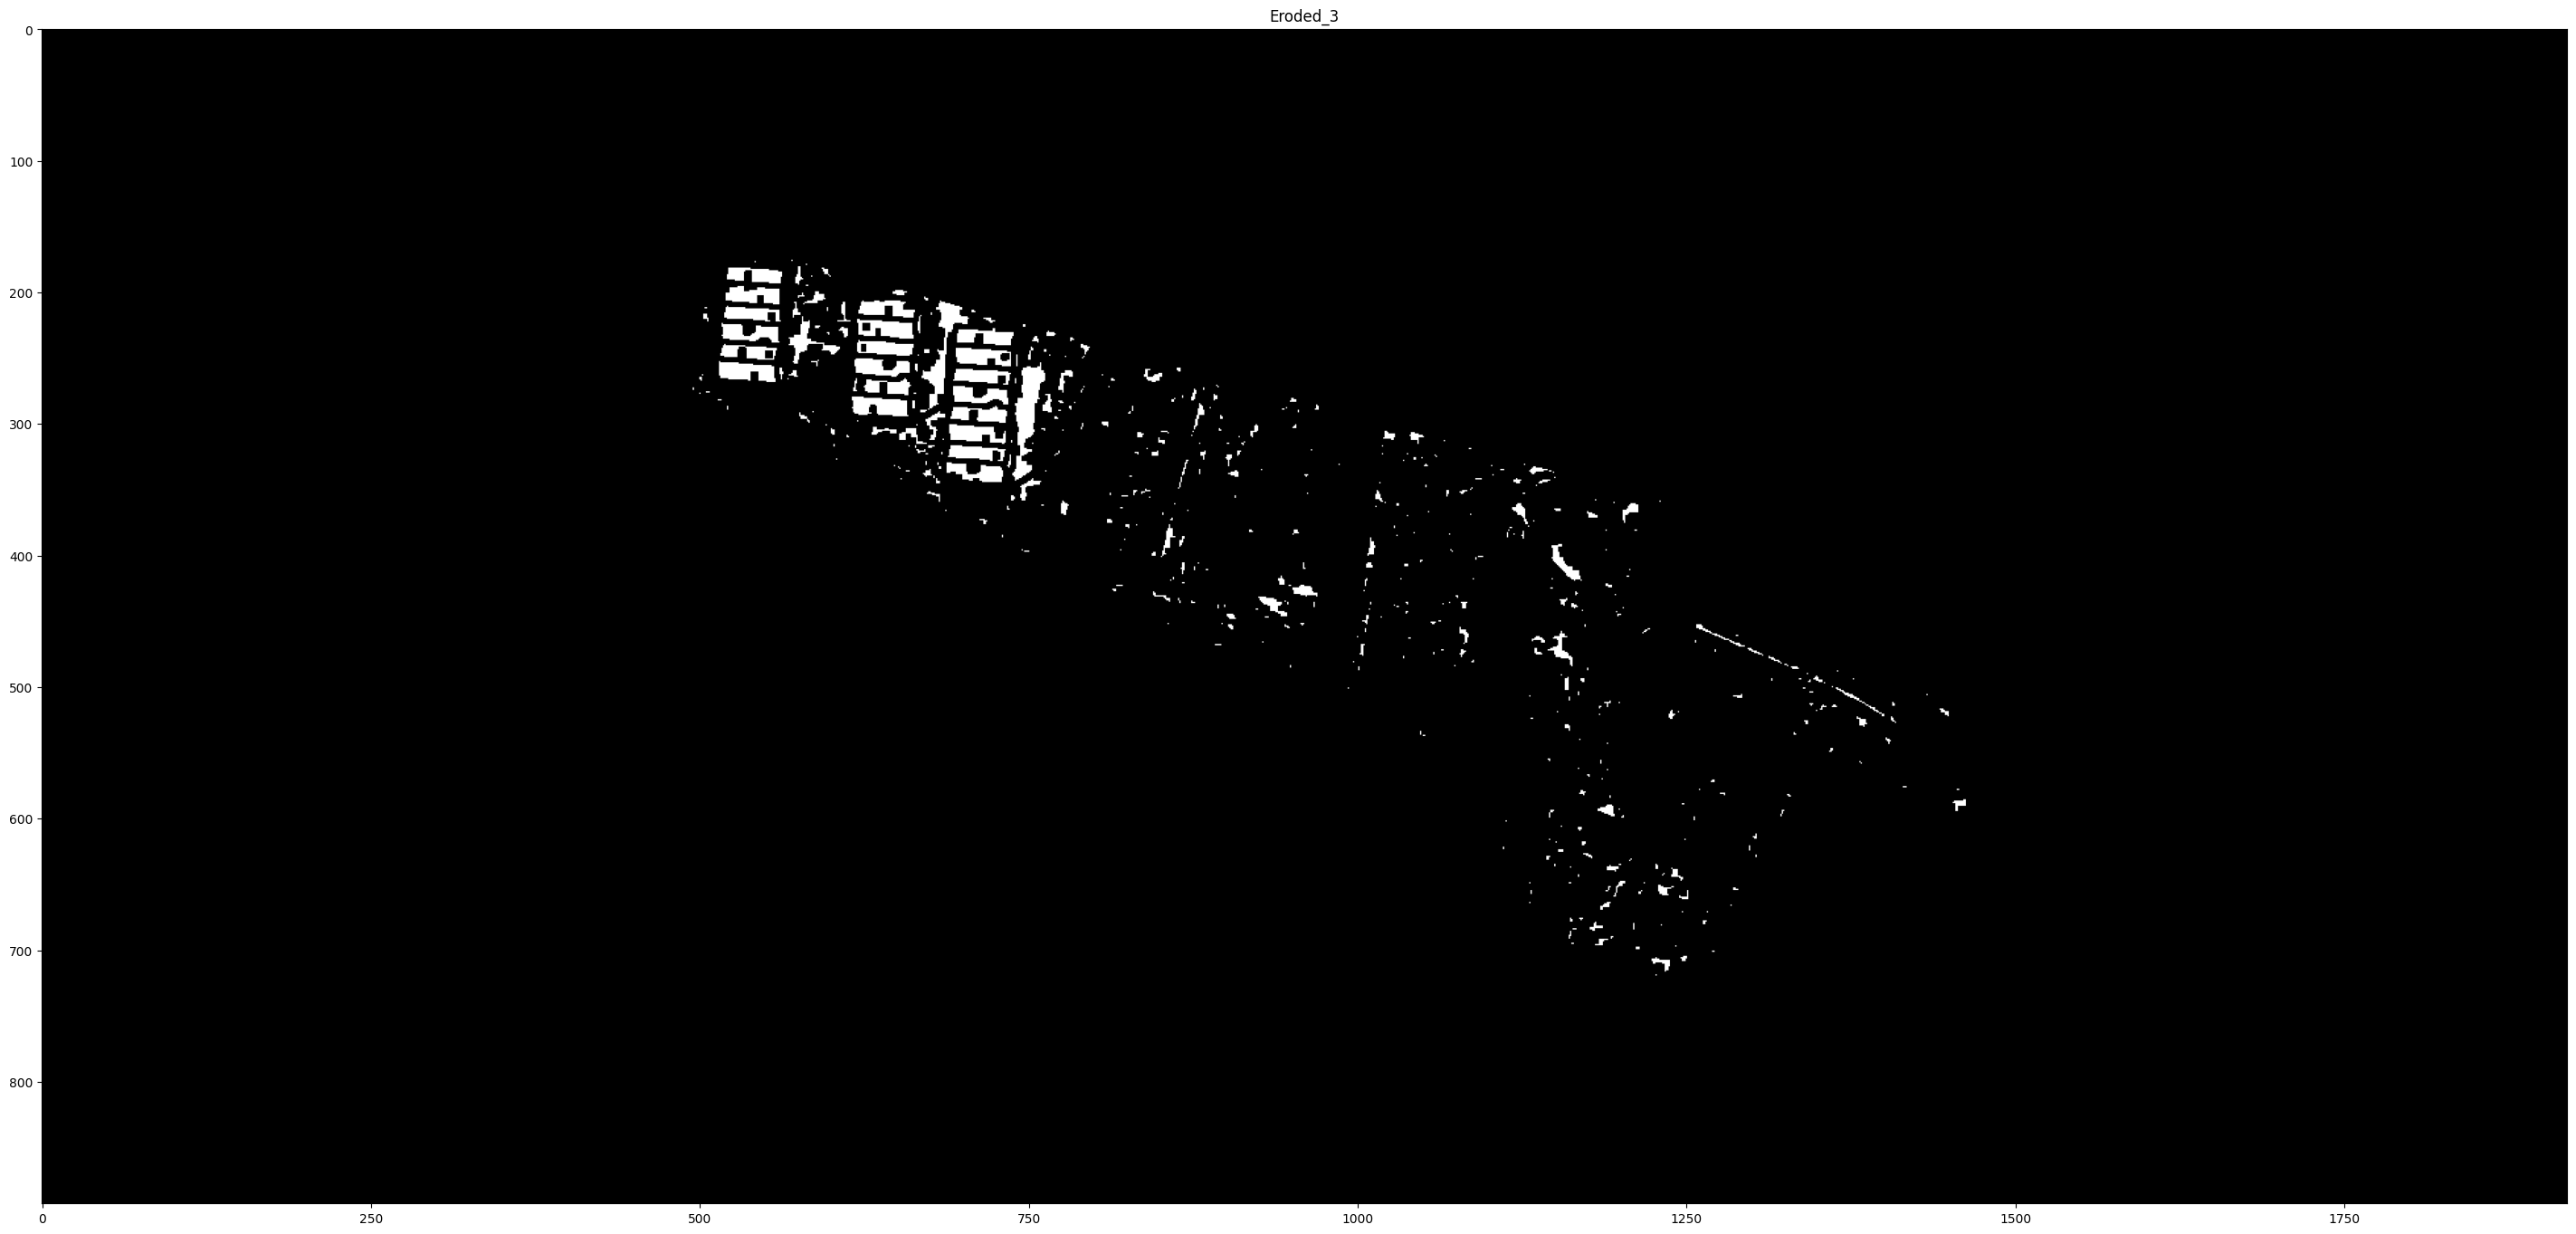

In [121]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# erosion
eroded_3 = cv2.erode(dilated_2, kernel, iterations=3)

plt.figure(figsize=(36,36))
plt.imshow(eroded_3, cmap="gray")
plt.title("Eroded_3")
plt.show()

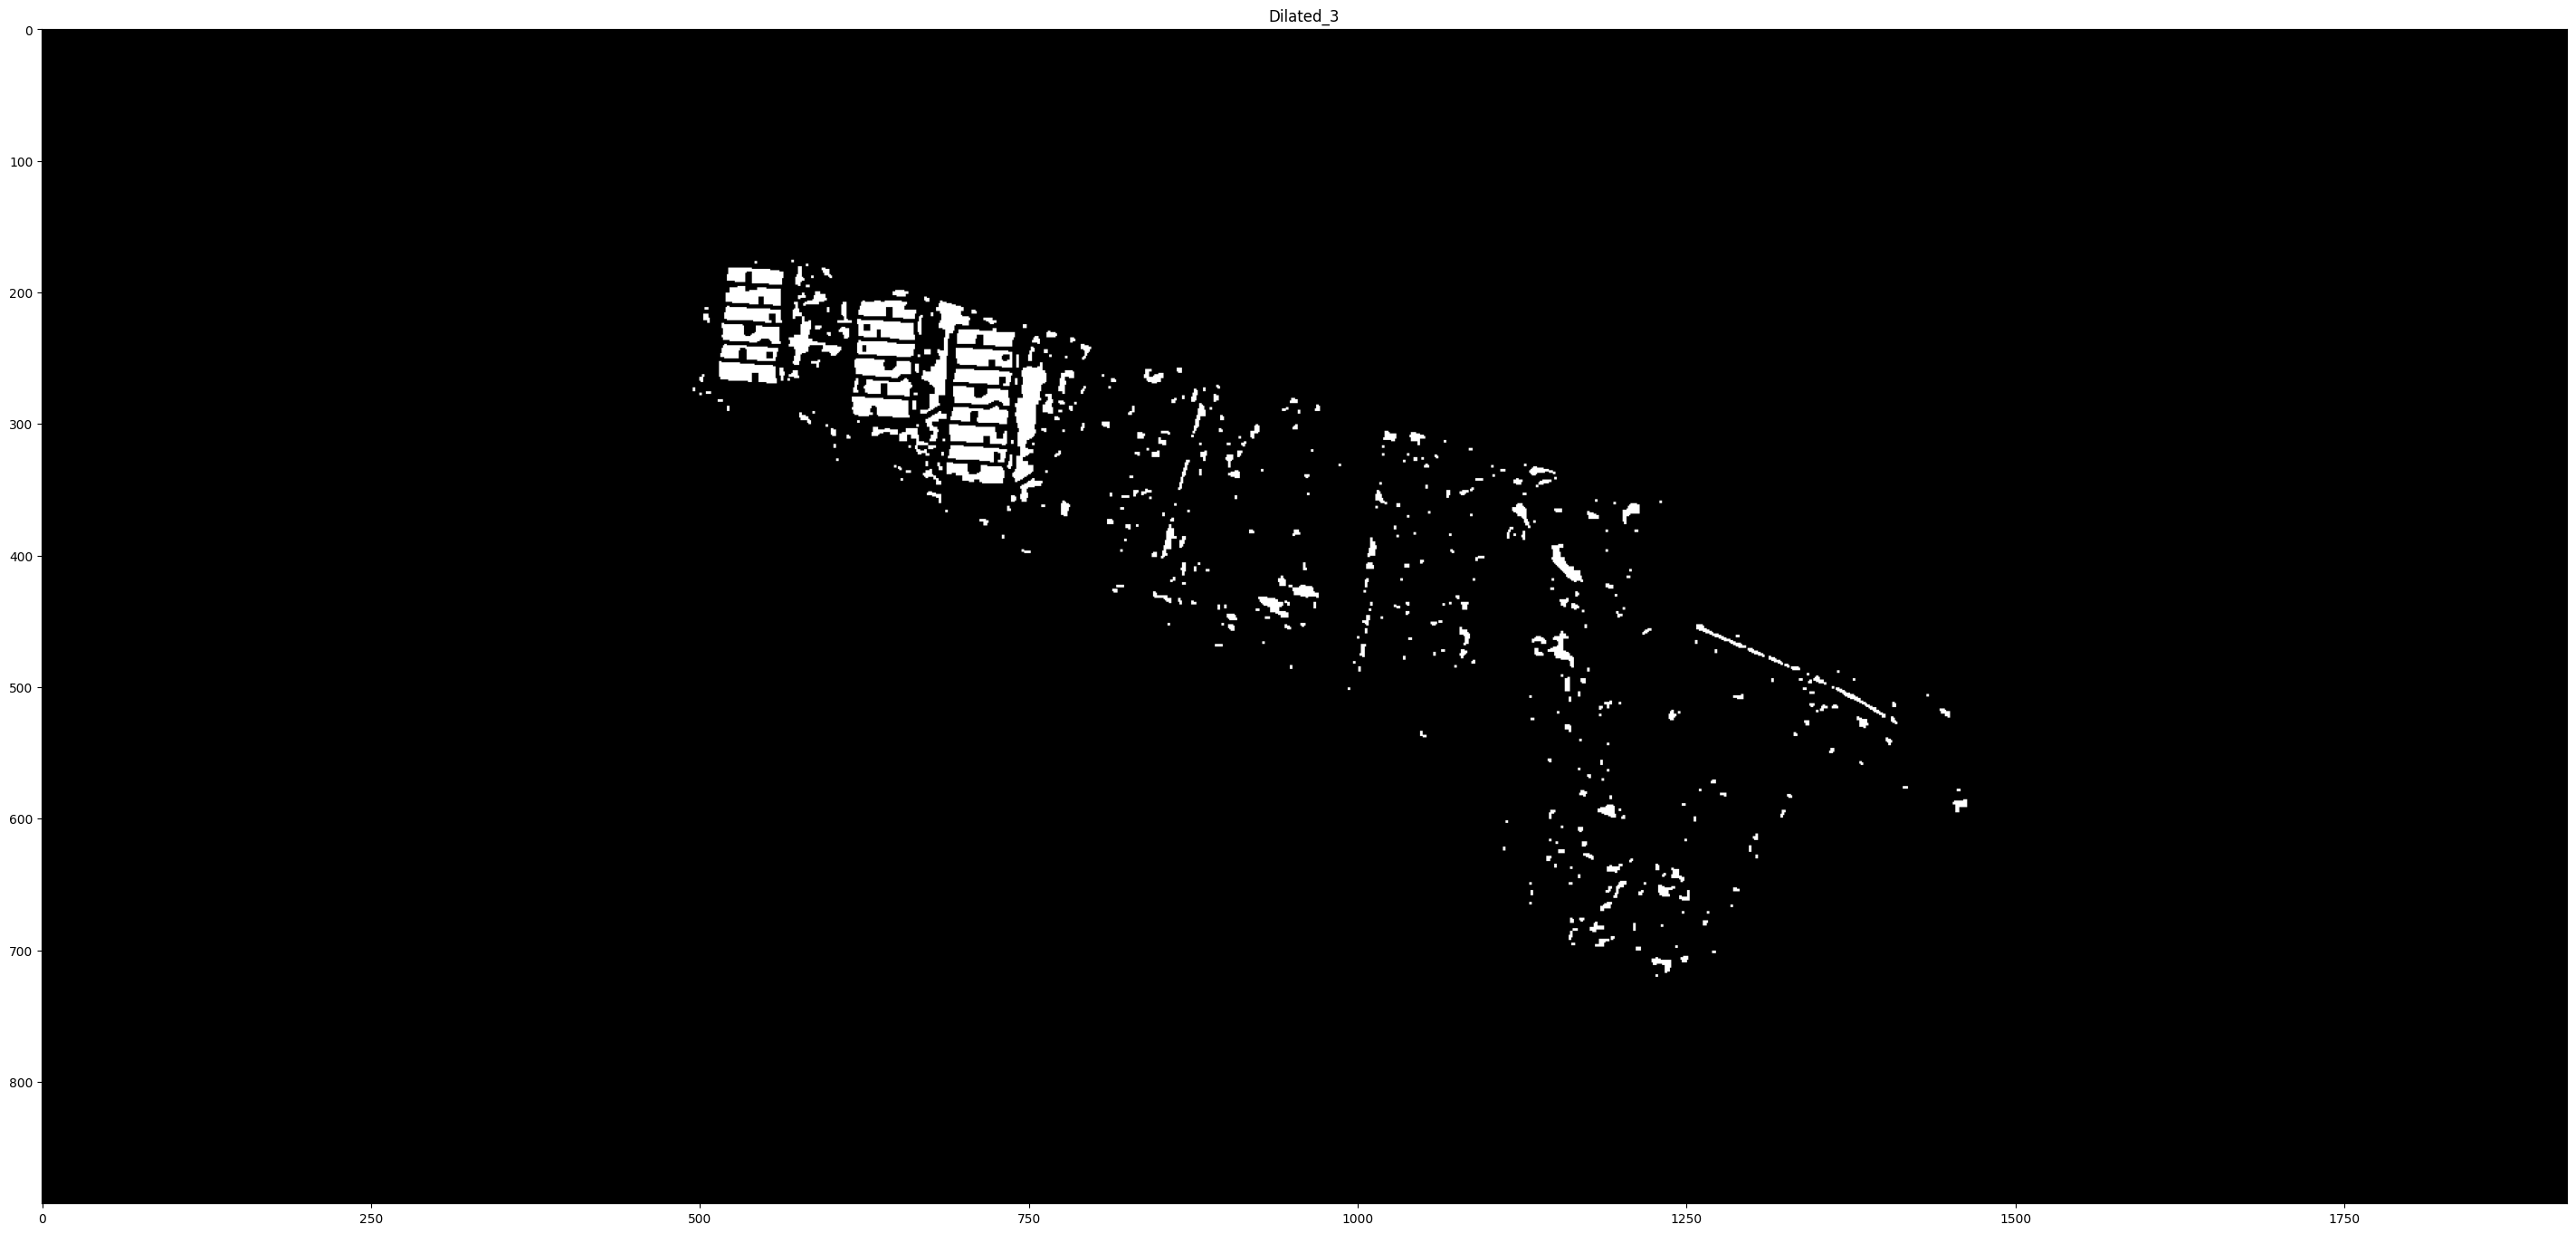

In [122]:
# kernel 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# dilatation
dilated_3 = cv2.dilate(eroded_3, kernel, iterations=1)

plt.figure(figsize=(36,36))
plt.imshow(dilated_3, cmap="gray")
plt.title("Dilated_3")
plt.show()

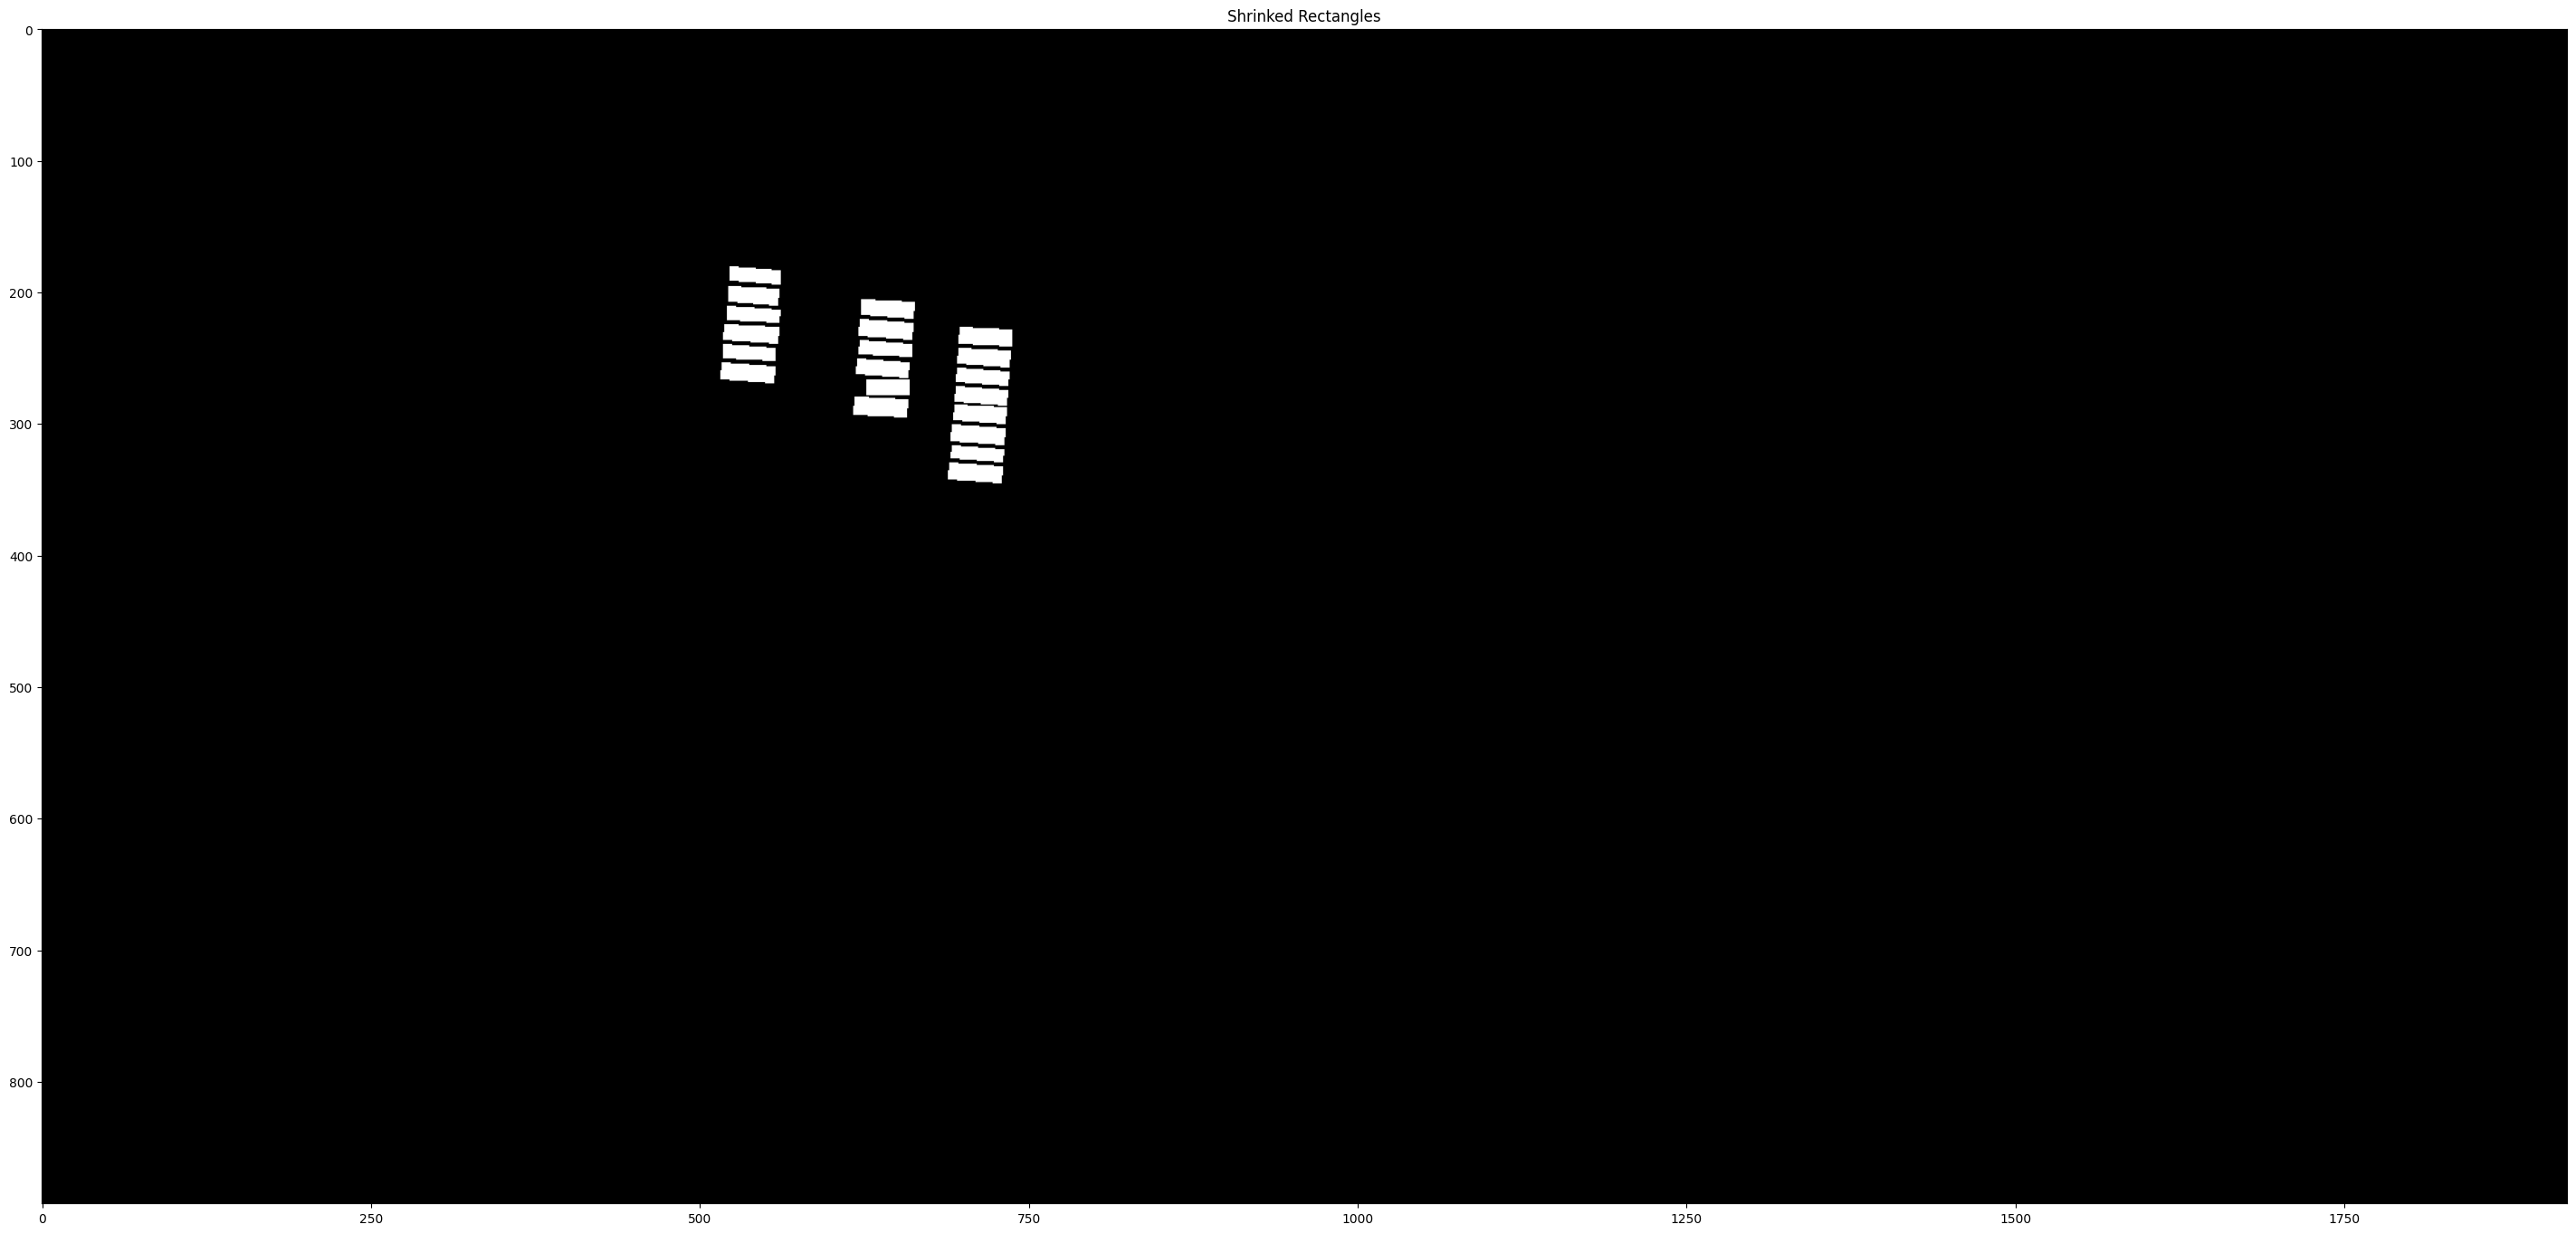

In [126]:
def rectangularize_mask_shrink(binary_mask: np.ndarray, min_area: int, min_fill_ratio: float = 0.2, shrink_px: int = 1) -> np.ndarray:
    """
    Replaces each component in the mask with its minimum rectangle (minAreaRect)
    if it meets the area and fill criteria of the outline, and then
    shrinks the rectangles by shrink_px towards the center.

    Parameters:
    binary_mask: np.ndarray
    Binary input mask (0/255).
    min_area: int
    Minimum area of the rectangle to be preserved.
    min_fill_ratio: float
    Minimum ratio of the outline area to the rectangle area (0-1).
    shrink_px: int
    How many pixels to subtract from the rectangle's edges.

    Returns:
    np.ndarray
    Mask with shrunk rectangles.
    """
    _, mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rect_mask = np.zeros_like(mask)
    drew_any = False

    for contour in contours:
        rect = cv2.minAreaRect(contour)
        (w, h) = rect[1]

        rect_area = float(w) * float(h)
        if rect_area < max(0, int(min_area)):
            continue

        contour_area = cv2.contourArea(contour)
        fill_ratio = contour_area / rect_area
        if fill_ratio < min_fill_ratio:
            continue

        box = cv2.boxPoints(rect).astype(np.float32)

        # Shrink the rectangle by shrink_px towards the center
        center = np.mean(box, axis=0)
        direction = box - center
        length = np.linalg.norm(direction, axis=1, keepdims=True)
        length[length == 0] = 1  # we avoid dividing by 0
        shrink_factor = np.maximum((length - shrink_px) / length, 0)
        box_shrink = center + direction * shrink_factor
        box_shrink = np.round(box_shrink).astype(np.int32)

        cv2.fillConvexPoly(rect_mask, box_shrink, 255)
        drew_any = True

    if not drew_any:
        return binary_mask

    return rect_mask

result_mask = rectangularize_mask_shrink(dilated_3, min_area=200, min_fill_ratio=0.55, shrink_px=2)

plt.figure(figsize=(36,36))
plt.imshow(result_mask, cmap="gray")
plt.title("Shrinked Rectangles")
plt.show()


In [128]:
# Counting segments operation

num_labels, labels = cv2.connectedComponents((result_mask > 0).astype(np.uint8))

num_segments = num_labels - 1

print(f"Liczba wykrytych segmentów = {int(num_segments / 2)}")


Liczba wykrytych segmentów = 10
